In [5]:
import pandas as pd
import sys
import os
import json
import time
import re
from tqdm import tqdm
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
from rapidfuzz import process, fuzz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, pairwise
import io
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from openai import OpenAI
from typing import Literal, TypedDict, Literal, Dict, Any, List, Union
import os
from typing import Any, Dict
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Literal, TypedDict, Literal, Dict, Any, List, Union
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import BaseTool, StructuredTool, tool
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph import MessagesState
import operator
import pandas as pd
from typing import List, Dict, Any, TypedDict
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Literal, TypedDict, Literal, Dict, Any, List
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import BaseTool, StructuredTool, tool
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from operator import add
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from collections import Counter
from treelib import Tree
import pickle

with io.open('/Users/emanueleferrari/desktop/Key.txt', 'r', encoding='utf-8') as file:
        api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
del api_key

client = OpenAI()

with open('references/items.json', 'r') as f:
        ITEMS = json.load(f)


In [21]:
folder_path = 'outputs/test'

sample = pd.read_csv('outputs/tree/tree_sample.csv')


filenames = sample.doc_id.to_list()
target_items = sample.item.to_list()
filenames = filenames[:]

dfs = []
for filename, target_item in zip(filenames, target_items):
    if os.path.exists(f'{folder_path}/{filename}/df_stage2early.parquet'):
        df = pd.read_parquet(f'{folder_path}/{filename}/df_stage2early.parquet')
        print(f"Document ID: {filename} from early stage loaded")
        df = pd.read_parquet(f'{folder_path}/{filename}/initial_df.parquet')
        with open(f'{folder_path}/{filename}/item_fuzz.json', 'r') as f:
            item_fuzz = json.load(f)

        for item in item_fuzz['detected']:
            i = int(item['id'])
            label = item['label']
            df.loc[df.index == i, 'item'] = label

        df.loc[df.item.notna(), 'type'] = 'item'
        df['item'] = df['item'].ffill()

        df['page_number'] = df['page_number'] + 1

        df = df[~df['clean_text'].str.contains(r'\bpart\s+i\b|\bpart\s+ii\b|\bpart\s+iii\b|\bpart\s+iv\b', case=False, na=False)]

        df = df[(df['is_noise'] == False) &
                (df['type'] != 'item') &
                (df['item'] == target_item)].copy()

        dfs.append(df)


Document ID: ts00_0000004127_0000004127-13-000056 from early stage loaded
Document ID: ts03_0000010456_0001193125-14-061654 from early stage loaded
Document ID: ts06_0000021076_0001206774-14-002682 from early stage loaded
Document ID: ts07_0000024545_0000024545-20-000005 from early stage loaded
Document ID: ts08_0000033185_0000033185-19-000007 from early stage loaded
Document ID: ts09_0000032604_0000032604-17-000046 from early stage loaded
Document ID: ts10_0001751788_0001751788-20-000007 from early stage loaded
Document ID: ts15_0000052988_0000052988-13-000140 from early stage loaded
Document ID: ts19_0000077360_0000077360-19-000006 from early stage loaded
Document ID: ts23_0000091419_0001193125-15-235197 from early stage loaded
Document ID: ts24_0000100493_0000100493-15-000109 from early stage loaded
Document ID: ts28_0000315293_0001628280-17-001652 from early stage loaded
Document ID: ts29_0000319201_0000319201-18-000045 from early stage loaded
Document ID: ts32_0000715957_000156459

# Tree

In [24]:
class HeadingNode:
    """
    Represents a single heading node in the tree.
    """
    def __init__(
        self,
        node_id: int,
        parent_id: int,
        depth: int,
        text: str,
        page_number: int,
        is_capitalized: bool,
        is_bold: bool,
        is_italic: bool
    ):
        self.id = node_id
        self.parent_id = parent_id
        self.depth = depth
        self.text = text
        self.page_number = page_number
        self.is_capitalized = is_capitalized
        self.is_bold = is_bold
        self.is_italic = is_italic


class HeadingTree:
    """
    A simple tree structure that assigns parent nodes automatically
    based on depth. 
    - The root node is depth=0, id=0.
    - next_id increments with each added node.
    """
    def __init__(
        self,
        root_text: str,
        root_page_number: int,
        root_is_capitalized: bool = True,
        root_is_bold: bool = True,
        root_is_italic: bool = False
    ):
        self.next_id = 0
        self.nodes = {}  # key: node_id -> value: HeadingNode

        # Create the root node
        root_node = HeadingNode(
            node_id=self.next_id,
            parent_id=-1,  # or None, indicating no parent
            depth=0,
            text=root_text,
            page_number=root_page_number,
            is_capitalized=root_is_capitalized,
            is_bold=root_is_bold,
            is_italic=root_is_italic
        )
        self.nodes[self.next_id] = root_node
        self.next_id += 1

    def add_node(
        self,
        depth: int,
        text: str,
        page_number: int,
        is_capitalized: bool,
        is_bold: bool,
        is_italic: bool
    ) -> int:
        """
        Adds a new node at the specified depth. Automatically determines
        the parent_id as the node with the highest ID at (depth - 1).
        Returns the newly created node's ID.
        """
        if depth < 0:
            raise ValueError(f"Depth cannot be negative (got {depth}).")

        # If depth=0, it's another root-level node, but you said there's only one root. 
        # If you allow multiple nodes at depth=0, you'd handle that scenario here.
        if depth == 0:
            parent_id = -1  # or None
        else:
            parent_id = self._find_parent_for_depth(depth - 1)

        new_node = HeadingNode(
            node_id=self.next_id,
            parent_id=parent_id,
            depth=depth,
            text=text,
            page_number=page_number,
            is_capitalized=is_capitalized,
            is_bold=is_bold,
            is_italic=is_italic
        )
        self.nodes[self.next_id] = new_node
        self.next_id += 1

        return new_node.id

    def _find_parent_for_depth(self, parent_depth: int) -> int:
        """
        Finds the node with the highest ID among those whose depth == parent_depth.
        Returns its ID, or raises an error if none found.
        """
        if parent_depth < 0:
            # Means we're adding a root-level node (depth=0).
            return -1  # or None, as a sentinel
        # Filter nodes by the desired depth
        candidates = [n for n in self.nodes.values() if n.depth == parent_depth]
        if not candidates:
            raise ValueError(f"No existing node with depth {parent_depth} found.")
        # Return the node with the largest ID
        max_id_node = max(candidates, key=lambda x: x.id)
        return max_id_node.id

    def find_last_node(self) -> HeadingNode:
        """
        Returns the node with the highest ID.
        """
        if not self.nodes:
            raise ValueError("No nodes in the tree.")
        max_id_node = max(self.nodes.values(), key=lambda x: x.id)
        return max_id_node

    def show_tree(self):
        """
        Prints a text-based representation of the tree, 
        indenting by depth. Only shows the `text` field.
        """
        # One simple way: 
        #   1) Find all nodes sorted by (depth, id) 
        #   2) Print them in ascending order
        sorted_nodes = sorted(self.nodes.values(), key=lambda x: (x.id))
        tree_str = ""
        for node in sorted_nodes:
            indent = "  " * node.depth
            s = (f"Depth {node.depth} {indent}-> {node.text}")
            tree_str += s + "\n"\
        
        return tree_str
        

    def path_to_last_node(self):
        """
        Returns a list of HeadingNode objects forming the path 
        from the root node to the node with the highest ID.
        """
        last_node = self.find_last_node()
        path = self._path_to_node(last_node.id)

        answer = ''
        for node in path:
            answer += (f"Depth {node.depth} -> '{node.text}'\n")
        return answer

    def _path_to_node(self, node_id: int):
        """
        Internal method: build a path from the root to the specified node.
        """
        path = []
        current = self.nodes[node_id]  # start at the target node
        while current is not None and current.parent_id != -1:
            path.append(current)
            parent_id = current.parent_id
            current = self.nodes[parent_id] if parent_id in self.nodes else None

        # Add the root if it’s not already in the path
        if current is not None:
            path.append(current)

        # Reverse so root is at the front
        path.reverse()
        return path
    
    def show_formatted_tree_in_notebook(self):
        """
        Displays the tree in a Jupyter notebook cell with 
        capitalized, bold, or italic formatting via Markdown.
        Indentation is done by repeating spaces for each node's depth.
        """
        from IPython.display import display, Markdown
        
        # Sort the nodes by (depth, id) so we print in ascending depth order
        sorted_nodes = sorted(self.nodes.values(), key=lambda x: (x.id))
        markdown_lines = []

        for node in sorted_nodes:
            # Convert text according to metadata:
            #  1) Uppercase if is_capitalized
            #  2) Wrap in ** for bold
            #  3) Wrap in * for italic
            text = node.text
            if node.is_capitalized:
                text = text.upper()
            if node.is_bold:
                text = f"**{text}**"
            if node.is_italic:
                text = f"*{text}*"
            
            # Indent according to depth
            indent = "    " * node.depth  # 4 spaces per depth
            line = f"{indent}- (ID {node.id}, depth={node.depth}) {text}"
            markdown_lines.append(line)
        
        # Display as Markdown in the notebook
        display(Markdown("\n".join(markdown_lines)))

    def show_tree_ascii(self):
        """
        Prints the tree in an ASCII branch style like:
        
        a
        ├── b
        │   ├── d
        │   └── e
        └── c
        
        where each letter corresponds to the node's text.
        Assumes the root is at id=0, and its children are connected by parent_id.
        """
        from collections import defaultdict
        
        # Build an adjacency list: parent_id -> list of child_ids
        adjacency = defaultdict(list)
        for node_id, node in self.nodes.items():
            if node.parent_id != -1:
                adjacency[node.parent_id].append(node_id)
        
        # Sort each parent's children by ID to ensure stable ordering
        for parent in adjacency:
            adjacency[parent].sort()
        lines = []

        def _build_subtree(current_id, prefix, is_last):
            connector = "└── " if is_last else "├── "
            line = prefix + connector + self.nodes[current_id].text
            lines.append(line)
            
            # Depending on whether this node is the last child, adjust the prefix
            new_prefix = prefix + ("    " if is_last else "│   ")
            
            children = adjacency[current_id]
            for i, child_id in enumerate(children):
                _build_subtree(child_id, new_prefix, i == len(children) - 1)

        # Check if root (id=0) is present
        if 0 not in self.nodes:
            return "No root found at id=0."
        
        # Append root node plainly, then recursively build children
        root = self.nodes[0]
        lines.append(root.text)  # root text as first line
        
        # Build subtree for children of root
        children_of_root = adjacency[0]
        for i, child_id in enumerate(children_of_root):
            _build_subtree(child_id, "", i == len(children_of_root) - 1)

        # Return the ASCII tree as a single string
        return "\n".join(lines)


    def get_max_depth(self) -> int:
        """
        Returns the maximum depth of the tree.
        """
        if not self.nodes:
            return 0
        return max(node.depth for node in self.nodes.values())



## Grap Definition

In [25]:
class GraphState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    tree: HeadingTree
    pages: List[str]
    page_numbers: List[int]
    current_page: int
    detected_headings: List[str]
    # next_action: str
    # notes_on_structure: str



In [26]:
# # Suppose you've already defined the HeadingNode and HeadingTree classes 
# # exactly as in the previous example.

# # 1. Initialize the tree with a root node
# tree = HeadingTree(
#     root_text="ITEM 1. BUSINESS",
#     root_page_number=1,
#     root_is_capitalized=True,
#     root_is_bold=True,
#     root_is_italic=False
# )

# # 2. Add headings/subheadings

# # heading 1, depth=1
# tree.add_node(
#     depth=1,
#     text="heading 1",
#     page_number=2,
#     is_capitalized=True,
#     is_bold=True,
#     is_italic=False
# )

# # heading 2, depth=1
# tree.add_node(
#     depth=1,
#     text="heading 2",
#     page_number=3,
#     is_capitalized=True,
#     is_bold=True,
#     is_italic=False
# )

# # subheading 1, depth=2
# tree.add_node(
#     depth=2,
#     text="subheading 1",
#     page_number=3,
#     is_capitalized=False,
#     is_bold=True,
#     is_italic=True
# )

# # subheading 2, depth=2
# tree.add_node(
#     depth=2,
#     text="subheading 2",
#     page_number=4,
#     is_capitalized=False,
#     is_bold=True,
#     is_italic=True
# )

# # heading 3, depth=1
# tree.add_node(
#     depth=1,
#     text="heading 3",
#     page_number=5,
#     is_capitalized=False,
#     is_bold=True,
#     is_italic=False
# )

# # subheading 2, depth=2
# tree.add_node(
#     depth=2,
#     text="subheading 3",
#     page_number=5,
#     is_capitalized=False,
#     is_bold=True,
#     is_italic=True
# )

# # sub sub heading 1, depth=3
# tree.add_node(
#     depth=3,
#     text="sub sub heading 1",
#     page_number=5,
#     is_capitalized=False,
#     is_bold=False,
#     is_italic=True
# )



# # 3. Show the entire tree
# print("=== TREE STRUCTURE ===")
# s = tree.show_tree()
# print(s)

# s = tree.show_tree_ascii()
# print("\n=== ASCII TREE ===")
# print(s)

# # 4. Find the path from the root to the last node (which is the newly added sub sub heading 1)
# print("\n=== PATH TO LAST NODE ===")
# path = tree.path_to_last_node()

# print(path)
# # 5. Display the tree in a formatted way in a Jupyter notebook cell
# print("\n=== FORMATTED TREE ===")
# tree.show_formatted_tree_in_notebook()


# Agents

## Extractor

In [106]:
class ExtractorAnswer(BaseModel):
    thoughts: List[str] = Field(..., description="The thoughts on the previous tree and on every candidate")
    detected_headings: List[str] = Field(..., description="The candidates headings and subheadings founded in the page, including markdown formatting. Empty list if no headings or subheadings were found.")


def extractor_node(state: GraphState) -> GraphState:
    """
    Calls an LLM to parse the current page text and the current tree,
    update the state with the detected headings, and move to the next node.
    """
    page_index = state["page_numbers"].index(state["current_page"])
    page_text = '==PAGE TEXT==\n' + str(state["pages"][page_index])
    ascii_tree = '== TREE ==\n' + state["tree"].show_tree_ascii() + '\n\n'


    # -------------- LLM CALL --------------
#     sys_messge_text = """You are an assistant specialized in extracting headings and subheadings from a 10-K filling.
# You process one page at a time.
# You will receive the previous heading tree and the text of the current page.
# The tree structure always starts with the root node that is a standard Item section required by the SEC.
# Text blocks of a page are separated by an empty line.

# Your task is to detect the headings and subheadings in the text, think about all possible candidates, and return them.
# You will use the markdwon format (capitalized, bold, italics) to help detecting headings and subheadings.

# Heading and sub heading format are cocherent within the same document. Therefore the ones already present in the tree can help you to detect the new ones.
# A heading or subheading is followed by a lower level subheading or a paragraph.
# Heading and sub headings tend to not terminate with a period.
# Usually, the heading is in one text block, very rarely it is split in two text blocks or merged with a paragraph. 
# In case the header is broken into multiple text blocks you will report the full message.
# In case the header is merged with a paragraph you will report the header.
# In case the header is merged at the beginning of a paragraph you will consider the possibility that is a subheading reep down in the heiarchy, that is reported in line with the paragraph.
# remind that the last element or its parent subheading must be also deep in the heiarchy. In that case you add '...' at the end of the subheading.

# You are able to identify table elements, even if they may have bold or italic text. You will not consider them as headings or subheadings.
# You write your thoughts about all possible candidates, and exclute the eventual table element from your final answer.

# If the first text block of a page is a paragraph, it is part of the last detected heading or subheading in the tree.

# A page may have only paragrahs and/or tables, in this case you will return an empty list of headings and subheadings.
# """


    sys_messge_text = """You are an assistant specialized in extracting headings and subheadings from a 10-K filing. You only process one page at a time. 

For each page:

Inputs Provided:
A heading tree from previous pages (i.e., the sequence of headings and subheadings identified so far).
The text of the current page, divided into text blocks separated by empty lines.

Context and Constraints:
A standard 10-K filing always begins with root-level items (e.g., "Item 1. Business," "Item 2. Properties," etc.).
New headings or subheadings on the current page should be integrated into the existing hierarchy whenever applicable.
Headings and subheadings typically do not end with a period.
Table elements, even if they contain bold or italic text, are not to be considered headings or subheadings.
If the first text block on a page is purely a paragraph (i.e., it is not a heading/subheading), it should be associated with the last detected heading or subheading from the previous page.
If no headings or subheadings are identified on a page (i.e., the page contains only paragraphs and/or tables), you should return an empty list.

Headings or subheadings can be:
A standalone text block.
Very rarely, split across multiple text blocks.
Merged at the beginning of a paragraph.

Identification Rules:

Headings/Subheadings vs. Paragraphs
A heading or subheading is typically followed by either a lower-level heading/subheading or a paragraph of text.
Do not consider a text block that ends with a table or references a table as a heading.

Broken or Merged Headings
If a heading or subheading is split across multiple text blocks, combine them into a single heading.
If a heading or subheading is merged with a paragraph, isolate just the heading portion.
If you suspect a heading is deeper in the hierarchy (e.g., a sub-subheading) and it appears in-line, you may append “...” at the end of the heading to reflect its deeper structure.

Use Markdown Formatting
Return your identified headings and subheadings using Markdown or another clear textual format (e.g., bold, italics, uppercase) to set them apart from paragraphs.

Output Requirements:
List of Newly Detected Headings/Subheadings
Present them in the correct hierarchical order.
Exclude any table elements from this list.

Empty List
If the page has no new headings or subheadings, return an empty list.

Rationale 
In your chain of thought, briefly consider all possible heading candidates and explain why you included or excluded them (particularly excluding table elements)"""

    parser = PydanticOutputParser(pydantic_object=ExtractorAnswer)
    sys_messge = (SystemMessage(content=sys_messge_text + "\n" + parser.get_format_instructions()))
    # print(sys_messge_text + '\n')


    human_message_text = ascii_tree + page_text
    human_message = HumanMessage(content=human_message_text)
    # print(human_message_text + '\n')
    

    messages = [sys_messge, human_message]

    llm = ChatOpenAI(model='gpt-4o', temperature=0)
    llm = llm.with_structured_output(ExtractorAnswer)
    # --------------------------------------

    # Call the LLM
    extractor_answer = llm.invoke(messages)

    # print(extractor_answer)
    time.sleep(1)

    extracted_headings = extractor_answer.detected_headings
    # Update state with the newly found headings

    if extracted_headings != []:
        state["detected_headings"] = extracted_headings

        # Remove consecutive duplicate headings
        unique_headings = []
        for i, heading in enumerate(extracted_headings):
            if i == 0 or heading != extracted_headings[i - 1]:
                unique_headings.append(heading)
        extracted_headings = unique_headings

        # If you also want to store the "thoughts" in messages for debugging, you could do:
        thoughts_str = "\n".join(extractor_answer.thoughts)
        state["messages"].append(AIMessage(content=f"Page: {state["current_page"]} \n\nExtractor Thoughts:\n{thoughts_str}\n\nExtracted headings: {str(extracted_headings)}"))
        print(f"Page: {state["current_page"]} \nExtracted headings: {str(extracted_headings)}")
        print('-'*50)

        update_dict = {
            "messages": state["messages"],
            "detected_headings": state["detected_headings"],
            # "current_page": state["current_page"] + 1
        }

        # Next node to run is "reconstructor"
        return Command(update=update_dict)
        # return state
    
    else:
        thoughts_str = "\n".join(extractor_answer.thoughts)
        state["messages"].append(AIMessage(content=f"Page: {state["current_page"]} \n\nExtractor Thoughts:\n{thoughts_str}\n\nNo heading found."))
        print(f"Page: {state["current_page"]} \nNo heading found.")
        print('-'*50)

        # If no headings were found, move to the next page
        update_dict = {
            "messages": state["messages"],
            "current_page": state["current_page"] + 1
        }

        # Next node to run is "reconstructor"
        return Command(update=update_dict)
        # return state
        


## Hierarchical Reconstructor


In [107]:
class HierarchicalRecontructorAnswer(BaseModel):
    thoughts: List[str] = Field(..., description="The thoughts regarding the provided tree their formatting and the candidate")
    candidate_depth: int = Field(..., description="The depth of the candidate in the tree")

def hierarchical_reconstructor_node(state: GraphState) -> GraphState:
    """
    Processes one heading from state['detected_headings'] at a time,
    calls an LLM to determine the depth, updates the tree accordingly.
    """
    page_index = state["page_numbers"].index(state["current_page"])
    page_text = '==PAGE TEXT==\n' + str(state["pages"][page_index])

    detected_headings = state["detected_headings"]

    tree = state["tree"]

    # -------------- LLM CALL --------------
    sys_messge_text = """You are an assistant specialized in determining the correct depth within a hierarchy for candidate headings or subheadings. 
    
You will receive:
An ASCII representation of the current heading tree. (Depth 0 is the root; only the first element of the tree can be at depth 0.)
The branch corresponding to the last identified heading (i.e., the path to the most recently added heading).
A candidate heading or subheading text to be placed in this hierarchy.

Your task is to evaluate the candidate’s appropriate depth. You must consider:
The semantic meaning (the textual content) of the candidate.
The styling (bold, italic, uppercase, etc.) used in existing headings in the tree.
Sibling relationships: The candidate may share the same depth as the last heading or it may be a sibling of a parent/grandparent heading.
Candidates that end in '...' are followed by paragraph on the same text block and may indicate a deeper hierarchy level.
The fact that no candadate should be assigned depth 0 (the root). Only the Item section definition can be at depth 0.
The fact that no depth level should be skipped (e.g., there cannot be a depth level 3 if no depth level 2 exist).

You must think aloud, providing your reasoning that explains how you arrived at the candidate’s depth. Then, provide your final classification.

You will produce a response indicating where the new candidate belongs in the hierarchy (e.g., depth 1, 2, 3, etc.), together with a short justification based on its relationship to the existing tree and its formatting style.
"""


    parser = PydanticOutputParser(pydantic_object=HierarchicalRecontructorAnswer)
    sys_messge = (SystemMessage(content=sys_messge_text + "\n" + parser.get_format_instructions()))
    # print(sys_messge_text + '\n')

    for candidate in detected_headings:

        ascii_tree = '== TREE ==\n' + tree.show_tree_ascii() + '\n\n'
        last_node_branch = '== LAST HEADING BRANCH==\n' + tree.path_to_last_node() + '\n\n'

        human_message_text = ascii_tree + last_node_branch + f'== CANDIDATE ==\n{candidate}'
        human_message = HumanMessage(content=human_message_text)
        # print(human_message_text + '\n')
        # print('~~~~~~~~~~')

        messages = [sys_messge, human_message]

        llm = ChatOpenAI(model='gpt-4o', temperature=0)
        llm = llm.with_structured_output(HierarchicalRecontructorAnswer)

        reconstructor_answer = llm.invoke(messages)

        # for t in reconstructor_answer.thoughts:
        #     print(t)
        # print(f"Depth: {reconstructor_answer.candidate_depth}, Candidate: {candidate}")
        # print('~ ~ ~ ~ ~ ~ ~ ~ ~ ~')

        if reconstructor_answer.candidate_depth <= 0:
            print(f"INVALID DEPTH: {reconstructor_answer.candidate_depth}, Candidate: {candidate}")
            continue

        # -------------- end simulation --------------

        # Check if the cleaned candidate starts with '**' to determine if it's bold

        # # Update the tree
        candidate_depth = reconstructor_answer.candidate_depth
        tree.add_node(
            depth=candidate_depth,
            text=candidate,
            page_number=state["current_page"],
            is_capitalized=(not any(char.islower() for char in candidate)),
            is_bold=candidate.replace('_', '').strip().startswith('**'),
            is_italic=candidate.replace('**', '').strip().startswith('_')
        )

        # # Optionally add the reconstructor's thoughts to messages:
        # state["messages"].append(AIMessage(
        #     content=f"Reconstructor Thoughts: {reconstructor_answer['thoughts']}"
        # ))

    # Update the state
    update_dict = {
        "messages": state["messages"],
        "tree": tree,
        "current_page": state["current_page"] + 1,
        "detected_headings": []
    }

    print(tree.show_tree())
    print('~'*50)

    return Command(update=update_dict)
    # return state


# GRAPH

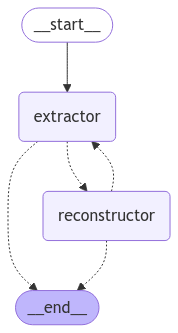

In [32]:
graph = StateGraph(GraphState)
graph.add_node("extractor", extractor_node)
graph.add_node("reconstructor", hierarchical_reconstructor_node)

# The flow:
#  - Start -> extractor -> reconstructor
#  - reconstructor can either keep calling itself if headings remain,
#    or go to extractor again if next page, or eventually end
# So we define the transitions:


def router_after_extractor(state: GraphState) -> Command[Literal["extractor", "reconstructor", "__end__"]]:
    if len(state["detected_headings"]) == 0:
        if state["current_page"] > max(state["page_numbers"]):
            return "__end__"
        # No headings found => go to reconstructor
        return "extractor"
    # After extraction, always go to the reconstructor
    return "reconstructor"


def router_after_reconstructor(state: GraphState) -> Command[Literal["extractor", "__end__"]]:
    # If we finished headings and still have pages left, go to "extractor" again
    if state["current_page"] > max(state["page_numbers"]):
        return "__end__"

    # Otherwise, no pages left => end
    return "extractor"

graph.add_edge(START, "extractor")
graph.add_conditional_edges("extractor", router_after_extractor) #, {'no headings': "extractor",'headings extracted': "reconstructor", 'no more pages': END})
graph.add_conditional_edges("reconstructor", router_after_reconstructor) #, {'more pages': "extractor", 'no more pages': END})

graph = graph.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


# Run Graph

### Small Extractor, Small Reconstructor

In [105]:
settings = 'extractor_4o-mini_reconstructor_4o-mini'

final_trees = []
final_tree_texts = []

for df in dfs:
    target_item = df.item.unique()[0]
    doc_id = df.doc_id.unique()[0]
    print('ID:', doc_id)
    print(f"Target item: {target_item}")


    print(df.doc_id.unique()[0])
    print(target_item)

    page_numbers = (sorted(df['page_number'].unique()))
    page_numbers = [int(i) for i in page_numbers]

    print('total pages:', len(page_numbers))
    current_page = int(page_numbers[0])

    pages = df.groupby('page_number')['md_text'].apply(lambda texts: '\n\n'.join(texts)).tolist()
    pages

    tree = HeadingTree(
        root_text=f'**{ITEMS[target_item].upper()}**',
        root_page_number=current_page,
        root_is_capitalized=True,
        root_is_bold=True,
        root_is_italic=False
    )

    # print(pages[0])

    state = GraphState(
        messages=[],
        tree=tree,
        pages=pages,
        page_numbers=page_numbers,
        current_page=current_page,
        detected_headings=[]
    )

    final_state = graph.invoke(state, {'recursion_limit': 250})

    t = final_state["tree"]

    ttext = t.show_tree_ascii()
    mtree = t.show_formatted_tree_in_notebook()

    print('== FINAL TREE ==')
    print(ttext)
    print(mtree)
    
    final_trees.append(t)
    final_tree_texts.append(ttext)

    print('~ - '*12)

    # Ensure the directory exists
    output_dir = f'outputs/tree/{doc_id}/{settings}/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    # Store the final tree with pickle
    with open(os.path.join(output_dir, 'final_tree.pkl'), 'wb') as f:
        pickle.dump(t, f)

    # Store the final tree text as txt
    with open(os.path.join(output_dir, 'final_tree.txt'), 'w') as f:
        f.write(ttext)

    # display(state)

ID: ts00_0000004127_0000004127-13-000056
Target item: item07
ts00_0000004127_0000004127-13-000056
item07
total pages: 9
Page: 25 
Extracted headings: ['**OVERVIEW**']
--------------------------------------------------
Depth 0 -> **ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
Depth 1   -> **OVERVIEW**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Page: 26 
Extracted headings: ['**RESULTS OF OPERATIONS**', '**FISCAL YEARS ENDED SEPTEMBER 27, 2013, SEPTEMBER 28, 2012, AND SEPTEMBER 30, 2011.**', '**GENERAL**']
--------------------------------------------------
Depth 0 -> **ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
Depth 1   -> **OVERVIEW**
Depth 1   -> **RESULTS OF OPERATIONS**
Depth 2     -> **FISCAL YEARS ENDED SEPTEMBER 27, 2013, SEPTEMBER 28, 2012, AND SEPTEMBER 30, 2011.**
Depth 1   -> **GENERAL**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Page: 27 
Extracted headin

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) ****OVERVIEW****
    - (ID 2, depth=1) ****RESULTS OF OPERATIONS****
        - (ID 3, depth=2) ****FISCAL YEARS ENDED SEPTEMBER 27, 2013, SEPTEMBER 28, 2012, AND SEPTEMBER 30, 2011.****
    - (ID 4, depth=1) ****GENERAL****
    - (ID 5, depth=1) ****NET REVENUE****
    - (ID 6, depth=1) ****GROSS PROFIT****
    - (ID 7, depth=1) ****RESEARCH AND DEVELOPMENT****
    - (ID 8, depth=1) ****SELLING, GENERAL AND ADMINISTRATIVE****
    - (ID 9, depth=1) ****AMORTIZATION OF INTANGIBLES****
    - (ID 10, depth=1) ****RESTRUCTURING AND OTHER CHARGES****
    - (ID 11, depth=1) ****PROVISION FOR INCOME TAXES****
    - (ID 12, depth=1) ****LIQUIDITY AND CAPITAL RESOURCES****
        - (ID 13, depth=2) *****_Cash Flow from Operating Activities:_*****
        - (ID 14, depth=2) *****_Cash Flow from Investing Activities:_*****
        - (ID 15, depth=2) *****_Cash Flow from Financing Activities:_*****
        - (ID 16, depth=2) *****_Liquidity:_*****
    - (ID 17, depth=1) ****OFF-BALANCE SHEET ARRANGEMENTS****
    - (ID 18, depth=1) ****CONTRACTUAL CASH FLOWS****
    - (ID 19, depth=1) ****CRITICAL ACCOUNTING ESTIMATES****
        - (ID 20, depth=2) *_Revenue Recognition._*
        - (ID 21, depth=2) *_Inventory Valuation._*
        - (ID 22, depth=2) *_Impairment of Long-Lived Assets._*
        - (ID 23, depth=2) *_Business Combinations._*
        - (ID 24, depth=2) *_Share-Based Compensation._*
    - (ID 25, depth=1) ****OTHER MATTERS****

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **OVERVIEW**
├── **RESULTS OF OPERATIONS**
│   └── **FISCAL YEARS ENDED SEPTEMBER 27, 2013, SEPTEMBER 28, 2012, AND SEPTEMBER 30, 2011.**
├── **GENERAL**
├── **NET REVENUE**
├── **GROSS PROFIT**
├── **RESEARCH AND DEVELOPMENT**
├── **SELLING, GENERAL AND ADMINISTRATIVE**
├── **AMORTIZATION OF INTANGIBLES**
├── **RESTRUCTURING AND OTHER CHARGES**
├── **PROVISION FOR INCOME TAXES**
├── **LIQUIDITY AND CAPITAL RESOURCES**
│   ├── **_Cash Flow from Operating Activities:_**
│   ├── **_Cash Flow from Investing Activities:_**
│   ├── **_Cash Flow from Financing Activities:_**
│   └── **_Liquidity:_**
├── **OFF-BALANCE SHEET ARRANGEMENTS**
├── **CONTRACTUAL CASH FLOWS**
├── **CRITICAL ACCOUNTING ESTIMATES**
│   ├── _Revenue Recognition._
│   ├── _Inventory Valuation._
│   ├── _Impairment of Long-Lived Assets._
│   ├── _Business Combinations._
│   └── _Share-Based Compensation.

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****Company Overview****
    - (ID 2, depth=1) ****Business Segments and Products****
        - (ID 3, depth=2) ****Sales and Distribution****
        - (ID 4, depth=2) ****International Operations****
        - (ID 5, depth=2) ****Contractual Arrangements****
        - (ID 6, depth=2) ****Raw Materials****
        - (ID 7, depth=2) ****Competition and Healthcare Cost Containment****
        - (ID 8, depth=2) ****Intellectual Property****
        - (ID 9, depth=2) ****Research and Development****
        - (ID 10, depth=2) ****Quality Management****
        - (ID 11, depth=2) ****Government Regulation****
        - (ID 12, depth=2) ****Employees****
    - (ID 13, depth=1) ****Available Information****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **Company Overview**
├── **Business Segments and Products**
│   ├── **Sales and Distribution**
│   ├── **International Operations**
│   ├── **Contractual Arrangements**
│   ├── **Raw Materials**
│   ├── **Competition and Healthcare Cost Containment**
│   ├── **Intellectual Property**
│   ├── **Research and Development**
│   ├── **Quality Management**
│   ├── **Government Regulation**
│   └── **Employees**
└── **Available Information**
None
~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - 
ID: ts06_0000021076_0001206774-14-002682
Target item: item01a
ts06_0000021076_0001206774-14-002682
item01a
total pages: 10
Page: 10 
Extracted headings: ['**The Company is subject to risks related to its international operations.**']
--------------------------------------------------
Depth 0 -> **ITEM 1A. RISK FACTORS**
Depth 1   -> **The Company is subject to risks related to its international operations.**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
P

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****The Company is subject to risks related to its international operations.****
    - (ID 2, depth=1) ****The Company faces intense competition in its markets, which could lead to reduced net sales, profitability and cash flow.****
    - (ID 3, depth=1) ****Unfavorable worldwide, regional and local economic conditions and financial market volatility may negatively impact the Company and consumers of its products, which would negatively affect the Company’s financial performance and liquidity.****
    - (ID 4, depth=1) ****Volatility and increases in the costs of raw materials, energy, transportation, labor and other necessary supplies or services could harm the Company’s profits and cash flow.****
    - (ID 5, depth=1) ****Sales growth objectives may be difficult to achieve, and price increases, market and category declines and changes to the Company’s product and geographic mix may adversely impact the Company’s financial results.****
    - (ID 6, depth=1) ****Dependence on key customers could adversely affect the Company’s business, financial condition and results of operations.****
    - (ID 7, depth=1) ****Government regulations could impose material costs.****
    - (ID 8, depth=1) ****Reliance on a limited base of suppliers may result in disruptions to the Company’s business.****
    - (ID 9, depth=1) ****Profitability and cash flow could suffer if the Company is unable to successfully implement its strategies, generate anticipated cost savings and efficiencies or efficiently manage supply chain and manufacturing processes.****
    - (ID 10, depth=1) ****Product liability, commercial claims or other legal proceedings could adversely affect the Company’s sales and operating results, including cash flow.****
    - (ID 11, depth=1) ****The Company may not successfully develop and introduce new products and line extensions or successfully expand into adjacent categories and countries, which could adversely impact its financial results.****
    - (ID 12, depth=1) ****Acquisitions, new venture investments and divestitures may not be successful, which could impact the Company’s results.****
    - (ID 13, depth=1) ****Cyber attacks, privacy breaches or a failure of key information technology systems could adversely impact the Company’s ability to conduct business.****
    - (ID 14, depth=1) ****Loss of, or inability to attract, key personnel could adversely impact the Company’s business.****
    - (ID 15, depth=1) ****Harm to the Company’s reputation or the reputation of one or more of its leading brands could have an adverse effect on the business.****
    - (ID 16, depth=1) ****Environmental matters create potential liabilities.****
    - (ID 17, depth=1) ****The facilities of the Company and its suppliers are subject to disruption by events beyond the Company’s control.****
    - (ID 18, depth=1) ****Failure to maximize, successfully assert or successfully defend the Company’s intellectual property rights could impact its competitiveness.****
    - (ID 19, depth=1) ****If the Company is found to have infringed the intellectual property rights of others or cannot obtain necessary intellectual property rights from others, its competitiveness could be negatively impacted.****
    - (ID 20, depth=1) ****The Company’s substantial indebtedness could adversely affect its operations and financial results and prevent the Company from fulfilling its obligations, and the Company may incur substantially more debt in the future, which could exacerbate these risks.****
    - (ID 21, depth=1) ****The Company’s continued growth and expansion and reliance on third-party service providers could adversely affect its internal control over financial reporting, which could harm its business and financial results.****
    - (ID 22, depth=1) ****The Company’s judgments regarding the accounting for tax positions and the resolution of tax disputes may impact the Company’s earnings and cash flow.****
    - (ID 23, depth=1) ****The estimates and assumptions on which the Company’s financial statement projections are based may prove to be inaccurate, which may cause its actual results to materially differ from such projections, which may adversely affect the Company’s future cash flows and stock price.****
    - (ID 24, depth=1) ****The Company may not continue to pay dividends or repurchase its stock.****
    - (ID 25, depth=1) ****The Company’s business could be negatively impacted as a result of stockholder activism or an unsolicited takeover proposal or a proxy contest.****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **The Company is subject to risks related to its international operations.**
├── **The Company faces intense competition in its markets, which could lead to reduced net sales, profitability and cash flow.**
├── **Unfavorable worldwide, regional and local economic conditions and financial market volatility may negatively impact the Company and consumers of its products, which would negatively affect the Company’s financial performance and liquidity.**
├── **Volatility and increases in the costs of raw materials, energy, transportation, labor and other necessary supplies or services could harm the Company’s profits and cash flow.**
├── **Sales growth objectives may be difficult to achieve, and price increases, market and category declines and changes to the Company’s product and geographic mix may adversely impact the Company’s financial results.**
├── **Dependence on key customers could adversely affect the Company’s business, financial con

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****Background****
    - (ID 2, depth=1) ****Revitalization Plan****
    - (ID 3, depth=1) ****Industry Overview****
        - (ID 4, depth=2) *****_Global Competitors' Market Capitalization_*****
        - (ID 5, depth=2) *****_Our Products_*****
        - (ID 6, depth=2) *****_Brands sold in the U.S._*****
        - (ID 7, depth=2) *****_Brands sold in Canada_*****
    - (ID 8, depth=1) ****Licensed premium import brands[(1)]****
            - (ID 9, depth=3) *****_Brands sold in Europe_*****
        - (ID 10, depth=2) *****_Brands sold in International_*****
    - (ID 11, depth=1) ****Our Segments****
        - (ID 12, depth=2) *****_United States Segment_*****
        - (ID 13, depth=2) *_Manufacturing, Production and Packaging_*
        - (ID 14, depth=2) *_Brewing Raw Materials_*
        - (ID 15, depth=2) *_Packaging Materials_*
        - (ID 16, depth=2) *_Contract Manufacturing_*
    - (ID 17, depth=1) *_Seasonality of the Business_*
    - (ID 18, depth=1) *_Known Trends and Competitive Conditions_*
    - (ID 19, depth=1) *_2019 U.S. Beer Industry Overview_*
        - (ID 20, depth=2) *_Our Competitive Position_*
    - (ID 21, depth=1) *_Regulation_*
        - (ID 22, depth=2) *****_Canada Segment_*****
    - (ID 23, depth=1) *_Sales and Distribution_*
    - (ID 24, depth=1) *_Channels_*
        - (ID 25, depth=2) *_Province of Ontario_*
        - (ID 26, depth=2) *_Province of Québec_*
        - (ID 27, depth=2) *_Province of British Columbia_*
        - (ID 28, depth=2) *_Province of Alberta_*
        - (ID 29, depth=2) *_Other Provinces_*
    - (ID 30, depth=1) *_2019 Canada Beer Industry Overview_*
        - (ID 31, depth=2) *****_Europe Segment_*****
    - (ID 32, depth=1) *_Sales and Distribution_*
        - (ID 33, depth=2) *_Channels_*
    - (ID 34, depth=1) *_Seasonality of Business_*
        - (ID 35, depth=2) *_Known Trends and Competitive Conditions_*
    - (ID 36, depth=1) *_2019 Europe Beer Industry Overview_*
        - (ID 37, depth=2) *_Our Competitive Position_*
    - (ID 38, depth=1) *_Regulation_*
        - (ID 39, depth=2) *****_International Segment_*****
        - (ID 40, depth=2) *_Latin America_*
        - (ID 41, depth=2) *_Asia Pacific and Africa_*
    - (ID 42, depth=1) ****Corporate****
    - (ID 43, depth=1) ****Other Information****
        - (ID 44, depth=2) *****_Global Intellectual Property_*****
        - (ID 45, depth=2) *****_Sustainability_*****
        - (ID 46, depth=2) ****Environmental Matters****
    - (ID 47, depth=1) ****Employees****
    - (ID 48, depth=1) ****Available Information****
    - (ID 49, depth=1) ****Information About Our Executive Officers****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **Background**
├── **Revitalization Plan**
├── **Industry Overview**
│   ├── **_Global Competitors' Market Capitalization_**
│   ├── **_Our Products_**
│   ├── **_Brands sold in the U.S._**
│   └── **_Brands sold in Canada_**
│       └── **_Brands sold in Europe_**
├── **Licensed premium import brands[(1)]**
│   └── **_Brands sold in International_**
├── **Our Segments**
│   ├── **_United States Segment_**
│   ├── _Manufacturing, Production and Packaging_
│   ├── _Brewing Raw Materials_
│   ├── _Packaging Materials_
│   └── _Contract Manufacturing_
├── _Seasonality of the Business_
├── _Known Trends and Competitive Conditions_
├── _2019 U.S. Beer Industry Overview_
│   └── _Our Competitive Position_
├── _Regulation_
│   └── **_Canada Segment_**
├── _Sales and Distribution_
├── _Channels_
│   ├── _Province of Ontario_
│   ├── _Province of Québec_
│   ├── _Province of British Columbia_
│   ├── _Province of Alberta_
│   └── _Other Provinces_
├── _

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****Overview****
        - (ID 2, depth=2) - **U.S. Information Solutions (USIS)**
        - (ID 3, depth=2) - **International**
        - (ID 4, depth=2) - **Workforce Solutions**
        - (ID 5, depth=2) - **Global Consumer Solutions**
    - (ID 6, depth=1) ****2017 Cybersecurity Incident****
    - (ID 7, depth=1) ****Our Business Strategy****
        - (ID 8, depth=2) ****• Lead our industry in data security.****
        - (ID 9, depth=2) ****• Transform our technology.****
        - (ID 10, depth=2) ****• Lead in data and analytics, to develop unparalleled analytical insights leveraging Equifax’s unique data.****
        - (ID 11, depth=2) ****• Improve the consumer user experience.****
        - (ID 12, depth=2) ****• Foster a culture of customer centricity.****
        - (ID 13, depth=2) ****• Deliver growth while enhancing profitability and shareholder returns.****
        - (ID 14, depth=2) ****• Build a world-class Equifax team by investing in talent to drive our strategy and promote a culture of innovation.****
    - (ID 15, depth=1) ****Markets and Clients****
    - (ID 16, depth=1) ****Products and Services****
        - (ID 17, depth=2) ****USIS****
        - (ID 18, depth=2) ****Online Information Solutions****
        - (ID 19, depth=2) ****Mortgage Solutions****
        - (ID 20, depth=2) ****Financial Marketing Services****
        - (ID 21, depth=2) ****International****
            - (ID 22, depth=3) ****Europe.****
            - (ID 23, depth=3) ****Asia Pacific.****
            - (ID 24, depth=3) ****Latin America.****
            - (ID 25, depth=3) ****Canada.****
        - (ID 26, depth=2) ****Workforce Solutions****
            - (ID 27, depth=3) *_Verification Services_*
            - (ID 28, depth=3) *_Employer Services_*
            - (ID 29, depth=3) *_The Work Number®_*
        - (ID 30, depth=2) ****Global Consumer Solutions****
            - (ID 31, depth=3) ****Free Consumer Services****
    - (ID 32, depth=1) ****Seasonality****
    - (ID 33, depth=1) ****Competition****
    - (ID 34, depth=1) ****Technology and Intellectual Property****
    - (ID 35, depth=1) ****Governmental Regulation****
        - (ID 36, depth=2) *****_Summary of U.S. Regulation Relating to Consumer and Data Protection_*****
        - (ID 37, depth=2) ****State Laws and Regulation Relating to Consumer and Data Protection****
        - (ID 38, depth=2) *****_Summary of International Regulation Relating to Consumer and Data Protection_*****
        - (ID 39, depth=2) ****Tax Management Services****
    - (ID 40, depth=1) ****Personnel****
    - (ID 41, depth=1) ****Forward-Looking Statements****
    - (ID 42, depth=1) ****Available Information****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **Overview**
│   ├── - **U.S. Information Solutions (USIS)**
│   ├── - **International**
│   ├── - **Workforce Solutions**
│   └── - **Global Consumer Solutions**
├── **2017 Cybersecurity Incident**
├── **Our Business Strategy**
│   ├── **• Lead our industry in data security.**
│   ├── **• Transform our technology.**
│   ├── **• Lead in data and analytics, to develop unparalleled analytical insights leveraging Equifax’s unique data.**
│   ├── **• Improve the consumer user experience.**
│   ├── **• Foster a culture of customer centricity.**
│   ├── **• Deliver growth while enhancing profitability and shareholder returns.**
│   └── **• Build a world-class Equifax team by investing in talent to drive our strategy and promote a culture of innovation.**
├── **Markets and Clients**
├── **Products and Services**
│   ├── **USIS**
│   ├── **Online Information Solutions**
│   ├── **Mortgage Solutions**
│   ├── **Financial Marketing Services**
│   ├── **I

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****AUTOMATION SOLUTIONS****
    - (ID 2, depth=1) ****Measurement & Analytical Instrumentation****
    - (ID 3, depth=1) ****Valves, Actuators & Regulators****
    - (ID 4, depth=1) ****Industrial Solutions****
    - (ID 5, depth=1) ****Process Control Systems & Solutions****
    - (ID 6, depth=1) ****Plantweb Digital Ecosystem****
    - (ID 7, depth=1) ****Industry Services****
    - (ID 8, depth=1) ****Distribution****
    - (ID 9, depth=1) ****Brands****
    - (ID 10, depth=1) ****COMMERCIAL & RESIDENTIAL SOLUTIONS****
    - (ID 11, depth=1) ****CLIMATE TECHNOLOGIES****
        - (ID 12, depth=2) ****Residential and Commercial Heating and Air Conditioning****
        - (ID 13, depth=2) ****Commercial and Industrial Refrigeration****
        - (ID 14, depth=2) ****Services and Solutions****
    - (ID 15, depth=1) ****Distribution****
    - (ID 16, depth=1) ****TOOLS & HOME PRODUCTS****
        - (ID 17, depth=2) Professional and Do-It-Yourself Tools
        - (ID 18, depth=2) Appliance Solutions
    - (ID 19, depth=1) Distribution
    - (ID 20, depth=1) ****DISCONTINUED OPERATIONS****
    - (ID 21, depth=1) ****PRODUCTION****
    - (ID 22, depth=1) ****RAW MATERIALS****
    - (ID 23, depth=1) ****PATENTS, TRADEMARKS AND LICENSES****
    - (ID 24, depth=1) ****BACKLOG****
    - (ID 25, depth=1) ****COMPETITION****
    - (ID 26, depth=1) ****RESEARCH AND DEVELOPMENT****
    - (ID 27, depth=1) ****ENVIRONMENT****
    - (ID 28, depth=1) ****EMPLOYEES****
    - (ID 29, depth=1) ****DOMESTIC AND FOREIGN OPERATIONS****
    - (ID 30, depth=1) ****INTERNET ACCESS****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **AUTOMATION SOLUTIONS**
├── **Measurement & Analytical Instrumentation**
├── **Valves, Actuators & Regulators**
├── **Industrial Solutions**
├── **Process Control Systems & Solutions**
├── **Plantweb Digital Ecosystem**
├── **Industry Services**
├── **Distribution**
├── **Brands**
├── **COMMERCIAL & RESIDENTIAL SOLUTIONS**
├── **CLIMATE TECHNOLOGIES**
│   ├── **Residential and Commercial Heating and Air Conditioning**
│   ├── **Commercial and Industrial Refrigeration**
│   └── **Services and Solutions**
├── **Distribution**
├── **TOOLS & HOME PRODUCTS**
│   ├── Professional and Do-It-Yourself Tools
│   └── Appliance Solutions
├── Distribution
├── **DISCONTINUED OPERATIONS**
├── **PRODUCTION**
├── **RAW MATERIALS**
├── **PATENTS, TRADEMARKS AND LICENSES**
├── **BACKLOG**
├── **COMPETITION**
├── **RESEARCH AND DEVELOPMENT**
├── **ENVIRONMENT**
├── **EMPLOYEES**
├── **DOMESTIC AND FOREIGN OPERATIONS**
└── **INTERNET ACCESS**
None
~ - ~ - ~ - ~ - 

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****THE COMPANY****
    - (ID 2, depth=1) ****Available Information****
    - (ID 3, depth=1) ****MERGER AND SEPARATION****
    - (ID 4, depth=1) ****About Dow****
    - (ID 5, depth=1) ****BUSINESS SEGMENTS AND PRODUCTS****
        - (ID 6, depth=2) ****PACKAGING & SPECIALTY PLASTICS****
        - (ID 7, depth=2) *_Hydrocarbons & Energy_*
            - (ID 8, depth=3) *_Packaging and Specialty Plastics_*
    - (ID 9, depth=1) ****Divestiture****
    - (ID 10, depth=1) ****Products****
    - (ID 11, depth=1) ****Joint Ventures****
    - (ID 12, depth=1) ****Current and Future Investments****
    - (ID 13, depth=1) ****INDUSTRIAL INTERMEDIATES & INFRASTRUCTURE****
        - (ID 14, depth=2) *_Industrial Solutions_*
        - (ID 15, depth=2) *_Polyurethanes & Construction Chemicals_*
    - (ID 16, depth=1) ****Products****
    - (ID 17, depth=1) ****PERFORMANCE MATERIALS & COATINGS****
        - (ID 18, depth=2) *_Coatings & Performance Monomers_*
        - (ID 19, depth=2) *_Consumer Solutions_*
    - (ID 20, depth=1) ****Products****
    - (ID 21, depth=1) ****CORPORATE****
    - (ID 22, depth=1) ****RAW MATERIALS****
    - (ID 23, depth=1) ****SIGNIFICANT CUSTOMERS AND PRODUCTS****
    - (ID 24, depth=1) ****PATENTS, LICENSES AND TRADEMARKS****
    - (ID 25, depth=1) ****PRINCIPAL PARTLY OWNED COMPANIES****
    - (ID 26, depth=1) ****PROTECTION OF THE ENVIRONMENT****
    - (ID 27, depth=1) ****EMPLOYEES****
    - (ID 28, depth=1) ****OTHER ACTIVITIES****
    - (ID 29, depth=1) ****EXECUTIVE OFFICERS OF THE REGISTRANT****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **THE COMPANY**
├── **Available Information**
├── **MERGER AND SEPARATION**
├── **About Dow**
├── **BUSINESS SEGMENTS AND PRODUCTS**
│   ├── **PACKAGING & SPECIALTY PLASTICS**
│   └── _Hydrocarbons & Energy_
│       └── _Packaging and Specialty Plastics_
├── **Divestiture**
├── **Products**
├── **Joint Ventures**
├── **Current and Future Investments**
├── **INDUSTRIAL INTERMEDIATES & INFRASTRUCTURE**
│   ├── _Industrial Solutions_
│   └── _Polyurethanes & Construction Chemicals_
├── **Products**
├── **PERFORMANCE MATERIALS & COATINGS**
│   ├── _Coatings & Performance Monomers_
│   └── _Consumer Solutions_
├── **Products**
├── **CORPORATE**
├── **RAW MATERIALS**
├── **SIGNIFICANT CUSTOMERS AND PRODUCTS**
├── **PATENTS, LICENSES AND TRADEMARKS**
├── **PRINCIPAL PARTLY OWNED COMPANIES**
├── **PROTECTION OF THE ENVIRONMENT**
├── **EMPLOYEES**
├── **OTHER ACTIVITIES**
└── **EXECUTIVE OFFICERS OF THE REGISTRANT**
None
~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - 

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****Construction and maintenance sites are inherently dangerous workplaces. If we fail to maintain safe work sites, we can be exposed to significant financial losses as well as civil and criminal liabilities.****
    - (ID 2, depth=1) ****Our project execution activities may result in liability for faulty engineering services.****
    - (ID 3, depth=1) ****The outcome of pending and future claims and litigation could have a material adverse impact on our business, financial condition, and results of operations.****
    - (ID 4, depth=1) ****We bear the risk of cost overruns in fixed-price contracts. We may experience reduced profits or, in some cases, losses under these contracts if costs increase above our estimates.****
    - (ID 5, depth=1) ****Our vulnerability to the cyclical nature of the markets in which our clients operate is exacerbated during economic downturns or time of political uncertainty.****
    - (ID 6, depth=1) ****Fluctuations in commodity prices may affect our customers’ investment decisions and therefore subject us to risks of cancellation, delays in existing work, or changes in the timing and funding of new awards.****
    - (ID 7, depth=1) ****Our continued success is dependent upon our ability to hire, retain, and utilize qualified personnel.****
    - (ID 8, depth=1) ****Contracts with the U.S. federal government and other governments and their agencies pose additional risks relating to future funding and compliance.****
    - (ID 9, depth=1) ****The contracts in our backlog may be adjusted, cancelled or suspended by our clients and, therefore, our backlog is not necessarily indicative of our future revenues or earnings.****
    - (ID 10, depth=1) ****Additionally, even if fully performed, our backlog is not a good indicator of our future gross margins.****
    - (ID 11, depth=1) ****Negative conditions in the credit and financial markets and delays in receiving client payments could result in liquidity problems.****
    - (ID 12, depth=1) ****Our use of joint ventures and partnerships exposes us to risks and uncertainties, many of which are outside of our control.****
    - (ID 13, depth=1) ****We are dependent on third parties to complete many of our contracts.****
    - (ID 14, depth=1) ****Maintaining adequate bonding and letter of credit capacity is necessary for us to successfully bid on and win some contracts.****
    - (ID 15, depth=1) ****Past and future environmental, heath, and safety laws could impose significant additional costs and liabilities.****
    - (ID 16, depth=1) ****If we fail to comply with federal, state, local or foreign governmental requirements, our business may be adversely affected.****
    - (ID 17, depth=1) ****Employee, agent or partner misconduct or our overall failure to comply with laws or regulations could weaken our ability to win contracts, which could result in reduced revenues and profits.****
    - (ID 18, depth=1) ****We could be adversely affected by violations of the U.S. Foreign Corrupt Practices Act and similar worldwide anti-bribery laws.****
    - (ID 19, depth=1) ****The loss of or a significant reduction in business from one or a few customers could have an adverse impact on us.****
    - (ID 20, depth=1) ****We engage in a highly competitive business. If we are unable to compete effectively, we could lose market share and our business and results of operations could be negatively impacted.****
    - (ID 21, depth=1) ****In addition to the risks discussed elsewhere in Risk Factors, our international operations are also exposed to additional risks and uncertainties including unfavorable political developments and weak foreign economies.****
    - (ID 22, depth=1) ****We work in international locations where there are high security risks, which could result in harm to our employees or unanticipated cost.****
    - (ID 23, depth=1) ****Foreign exchange risks may affect our ability to realize a profit from certain projects.****
    - (ID 24, depth=1) *****_Our business strategy relies in part on acquisitions to sustain our growth. Acquisitions of other companies present certain risks and uncertainties._*****
        - (ID 25, depth=2) *****_In the event we issue stock as consideration for certain acquisitions we may make, we could dilute share ownership._*****
    - (ID 26, depth=1) *****_Our quarterly results may fluctuate significantly, which could have a material negative effect on the price of our common stock._*****
    - (ID 27, depth=1) *****_Our actual results could differ from the estimates and assumptions used to prepare our financial statements._*****
    - (ID 28, depth=1) *****_An impairment charge of goodwill could have a material adverse impact on our financial condition and results of operations._*****
    - (ID 29, depth=1) *****_We may be required to contribute additional cash to meet any underfunded benefit obligations associated with retirement and post-retirement benefit plans we manage._*****
    - (ID 30, depth=1) *****_Rising inflation, interest rates, and/or construction costs could reduce the demand for our services as well as decrease our profit on our existing contracts, in particular with respect to_*****
    - (ID 31, depth=1) *****_We may be affected by market or regulatory responses to climate change._*****
    - (ID 32, depth=1) *****_Our effective tax rate may increase or decrease._*****
    - (ID 33, depth=1) *****_Systems and information technology interruption could adversely impact our ability to operate._*****
    - (ID 34, depth=1) *****_We may not be able to protect our intellectual property or that of our clients._*****
    - (ID 35, depth=1) *****_Our businesses could be materially and adversely affected by events outside of our control._*****
    - (ID 36, depth=1) *****_We are subject to professional standards, duties and statutory obligations on professional reports and opinions we issue, which could subject us to monetary damages._*****
    - (ID 37, depth=1) *****_Delaware law and our charter documents may impede or discourage a takeover or change of control._*****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **Construction and maintenance sites are inherently dangerous workplaces. If we fail to maintain safe work sites, we can be exposed to significant financial losses as well as civil and criminal liabilities.**
├── **Our project execution activities may result in liability for faulty engineering services.**
├── **The outcome of pending and future claims and litigation could have a material adverse impact on our business, financial condition, and results of operations.**
├── **We bear the risk of cost overruns in fixed-price contracts. We may experience reduced profits or, in some cases, losses under these contracts if costs increase above our estimates.**
├── **Our vulnerability to the cyclical nature of the markets in which our clients operate is exacerbated during economic downturns or time of political uncertainty.**
├── **Fluctuations in commodity prices may affect our customers’ investment decisions and therefore subject us to risks of 

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) *****_Forward-looking statements_*****
    - (ID 2, depth=1) *****_Overview_*****
    - (ID 3, depth=1) *****_Key trends and uncertainties regarding our existing business_*****
    - (ID 4, depth=1) ****CONSOLIDATED RESULTS OF OPERATIONS****
        - (ID 5, depth=2) *****_Net sales_*****
        - (ID 6, depth=2) *****_Gross profit_*****
        - (ID 7, depth=2) *****_Selling, general and administrative (“SG&A”)_*****
        - (ID 8, depth=2) *****_Net interest expense_*****
        - (ID 9, depth=2) *****_Loss on early extinguishment of debt_*****
        - (ID 10, depth=2) *****_Provision for income taxes_*****
    - (ID 11, depth=1) ****SEGMENT RESULTS OF OPERATIONS****
        - (ID 12, depth=2) ****Aquatic Systems****
            - (ID 13, depth=3) *****_Net sales_*****
            - (ID 14, depth=3) *****_Segment income_*****
        - (ID 15, depth=2) ****Filtration Solutions****
            - (ID 16, depth=3) *****_Net sales_*****
        - (ID 17, depth=2) ****Flow Technologies****
            - (ID 18, depth=3) *****_Net sales_*****
            - (ID 19, depth=3) *****_Segment income_*****
    - (ID 20, depth=1) ****LIQUIDITY AND CAPITAL RESOURCES****
        - (ID 21, depth=2) *****_Operating activities_*****
        - (ID 22, depth=2) *****_Investing activities_*****
        - (ID 23, depth=2) *****_Financing activities_*****
        - (ID 24, depth=2) *****_Authorized shares_*****
        - (ID 25, depth=2) *****_Share repurchases_*****
        - (ID 26, depth=2) *****_Dividends_*****
        - (ID 27, depth=2) *****_Contractual obligations_*****
        - (ID 28, depth=2) *****_Other financial measures_*****
        - (ID 29, depth=2) *****_Off-balance sheet arrangements_*****
    - (ID 30, depth=1) ****COMMITMENTS AND CONTINGENCIES****
        - (ID 31, depth=2) *****_Product liability claims_*****
        - (ID 32, depth=2) *****_Stand-by letters of credit, bank guarantees and bonds_*****
    - (ID 33, depth=1) ****NEW ACCOUNTING STANDARDS****
    - (ID 34, depth=1) ****CRITICAL ACCOUNTING POLICIES****
        - (ID 35, depth=2) *****_Impairment of goodwill and indefinite-lived intangibles_*****
        - (ID 36, depth=2) *****_Pension and other post-retirement plans_*****
        - (ID 37, depth=2) *_Discount rates_*
        - (ID 38, depth=2) *_Expected rate of return_*
        - (ID 39, depth=2) *****_Loss contingencies_*****
        - (ID 40, depth=2) *****_Income taxes_*****

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **_Forward-looking statements_**
├── **_Overview_**
├── **_Key trends and uncertainties regarding our existing business_**
├── **CONSOLIDATED RESULTS OF OPERATIONS**
│   ├── **_Net sales_**
│   ├── **_Gross profit_**
│   ├── **_Selling, general and administrative (“SG&A”)_**
│   ├── **_Net interest expense_**
│   ├── **_Loss on early extinguishment of debt_**
│   └── **_Provision for income taxes_**
├── **SEGMENT RESULTS OF OPERATIONS**
│   ├── **Aquatic Systems**
│   │   ├── **_Net sales_**
│   │   └── **_Segment income_**
│   ├── **Filtration Solutions**
│   │   └── **_Net sales_**
│   └── **Flow Technologies**
│       ├── **_Net sales_**
│       └── **_Segment income_**
├── **LIQUIDITY AND CAPITAL RESOURCES**
│   ├── **_Operating activities_**
│   ├── **_Investing activities_**
│   ├── **_Financing activities_**
│   ├── **_Authorized shares_**
│   ├── **_Share repur

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) - A significant interruption in the operation of any of our supply chain or distribution capabilities could have an adverse effect on our business, financial condition, and results of operations.
    - (ID 2, depth=1) - Our business could be harmed by strikes or work stoppages.
    - (ID 3, depth=1) - Our ability to competitively serve customers depends on the availability of reliable transportation. Increases in logistics and other transportation-related costs could adversely impact our results of operations.
    - (ID 4, depth=1) - Our operations are subject to the general risks of the food industry.
    - (ID 5, depth=1) - Changes in our relationships with significant customers, including the loss of our largest customer, could adversely affect our results of operations.
    - (ID 6, depth=1) - We operate in the competitive food industry and continued demand for our products may be affected by changes in consumer preferences.
    - (ID 7, depth=1) - The success of our business depends substantially on consumer perceptions of our brands.
    - (ID 8, depth=1) - We could be subject to adverse publicity or claims from consumers.
    - (ID 9, depth=1) - Our operations are subject to the general risks associated with acquisitions. Specifically, we may not realize all of the anticipated benefits of the acquisition of Big Heart or...
    - (ID 10, depth=1) - Weak financial performance, downgrades in our credit ratings, or disruptions in the financial markets may adversely affect our ability to access capital in the future.
    - (ID 11, depth=1) - Our substantial debt obligations could restrict our operations and financial condition.
    - (ID 12, depth=1) - Changes in tax, environmental, or other regulations and laws, or their application, or failure to comply with existing licensing, trade, and other regulations and laws could have a material adverse effect on our financial condition.
    - (ID 13, depth=1) - Our operations in certain developing markets expose us to regulatory risks.
    - (ID 14, depth=1) - Changes in climate or legal, regulatory, or market measures to address climate change may negatively affect our business and operations.
    - (ID 15, depth=1) - If our information technology systems fail to perform adequately or we are unable to protect such information technology systems against data corruption, cyber-based attacks, or network security breaches, our operations could be disrupted, and we may suffer financial damage or loss because of lost or misappropriated information.

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── - A significant interruption in the operation of any of our supply chain or distribution capabilities could have an adverse effect on our business, financial condition, and results of operations.
├── - Our business could be harmed by strikes or work stoppages.
├── - Our ability to competitively serve customers depends on the availability of reliable transportation. Increases in logistics and other transportation-related costs could adversely impact our results of operations.
├── - Our operations are subject to the general risks of the food industry.
├── - Changes in our relationships with significant customers, including the loss of our largest customer, could adversely affect our results of operations.
├── - We operate in the competitive food industry and continued demand for our products may be affected by changes in consumer preferences.
├── - The success of our business depends substantially on consumer perceptions of our brands.
├── -

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****The integration of The Hillshire Brands Company may be more difficult, costly or time consuming than expected, and the acquisition may not result in any or all of the anticipated benefits, including cost synergies.****
    - (ID 2, depth=1) ****Fluctuations in commodity prices and in the availability of raw materials, especially feed grains, live cattle, live swine and other inputs could negatively impact our earnings.****
    - (ID 3, depth=1) ****The prices we receive for our products may fluctuate due to competition from other food producers and processors.****
    - (ID 4, depth=1) ****Outbreaks of livestock diseases can adversely impact our ability to conduct our operations and demand for our products.****
    - (ID 5, depth=1) ****We are subject to risks associated with our international activities, which could negatively affect our sales to customers in foreign countries, as well as our operations and assets in such countries.****
    - (ID 6, depth=1) ****We depend on the availability of, and good relations with, our employees.****
    - (ID 7, depth=1) ****We depend on contract growers and independent producers to supply us with livestock.****
    - (ID 8, depth=1) ****If our products become contaminated, we may be subject to product liability claims and product recalls.****
    - (ID 9, depth=1) ****Changes in consumer preference and failure to maintain favorable consumer perception of our brands and products could negatively impact our business.****
    - (ID 10, depth=1) ****Failure to continually innovate and successfully launch new products and maintain our brand image through marketing investment could adversely impact our operating results.****
    - (ID 11, depth=1) ****Failure to leverage our brand value propositions to compete against private label products, especially during economic downturn, may adversely affect our profitability.****
    - (ID 12, depth=1) ****Our level of indebtedness and the terms of our indebtedness could negatively impact our business and liquidity position.****
    - (ID 13, depth=1) ****An impairment in the carrying value of our goodwill or indefinite life intangible assets could negatively impact our consolidated results of operations and net worth.****
    - (ID 14, depth=1) ****New or more stringent domestic and international government regulations could impose material costs on us and could adversely affect our business.****
    - (ID 15, depth=1) ****Legal claims, other regulatory enforcement actions, or failure to comply with applicable legal standards or requirements could affect our product sales, reputation and profitability.****
    - (ID 16, depth=1) ****The Company is subject to stringent environmental regulation and potentially subject to environmental litigation, proceedings, and investigations.****
    - (ID 17, depth=1) ****Failures or security breaches of our information technology systems could disrupt our operations and negatively impact our business.****
    - (ID 18, depth=1) ****If we pursue strategic acquisitions or divestitures, we may not be able to successfully consummate favorable transactions or successfully integrate acquired businesses.****
    - (ID 19, depth=1) ****Market fluctuations could negatively impact our operating results as we hedge certain transactions.****
    - (ID 20, depth=1) ****Deterioration of economic conditions could negatively impact our business.****
    - (ID 21, depth=1) ****The loss of one or more of our largest customers could negatively impact our business.****
    - (ID 22, depth=1) ****Extreme factors or forces beyond our control could negatively impact our business.****
    - (ID 23, depth=1) ****Failure to maximize or to successfully assert our intellectual property rights could impact our competitiveness.****
    - (ID 24, depth=1) ****Tyson Limited Partnership can exercise significant control.****
    - (ID 25, depth=1) ****We may incur additional tax expense or become subject to additional tax liabilities.****
    - (ID 26, depth=1) ****We could incur substantial tax liabilities as a result of the DEMB Master Blenders 1753 N.V (“DEMB”) Spin-Off.****
    - (ID 27, depth=1) ****Participation in a Multiemployer Pension Plan could adversely affect our business.****
    - (ID 28, depth=1) ****Volatility in the capital markets or interest rates could adversely impact our pension costs and the funded status of our pension plans.****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **The integration of The Hillshire Brands Company may be more difficult, costly or time consuming than expected, and the acquisition may not result in any or all of the anticipated benefits, including cost synergies.**
├── **Fluctuations in commodity prices and in the availability of raw materials, especially feed grains, live cattle, live swine and other inputs could negatively impact our earnings.**
├── **The prices we receive for our products may fluctuate due to competition from other food producers and processors.**
├── **Outbreaks of livestock diseases can adversely impact our ability to conduct our operations and demand for our products.**
├── **We are subject to risks associated with our international activities, which could negatively affect our sales to customers in foreign countries, as well as our operations and assets in such countries.**
├── **We depend on the availability of, and good relations with, our employees.**
├── **W

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****Risks Relating to the Company Generally****
    - (ID 2, depth=1) ****Competitive Risks****
    - (ID 3, depth=1) *****_Financial Risks_*****
        - (ID 4, depth=2) *_The benefits of our Redomestication may not be realized or may be offset in whole or in part by factors that we do not control._*
        - (ID 5, depth=2) *_Our global effective tax rate is subject to a variety of different factors, which could create volatility in that tax rate, expose us to greater than anticipated tax liabilities or cause us to adjust previously recognized tax assets and liabilities._*
        - (ID 6, depth=2) *_Changes in our accounting estimates and assumptions could negatively affect our financial position and results of operations._*
        - (ID 7, depth=2) *_We may be required to record goodwill or other long-lived asset impairment charges, which could result in a significant charge to earnings._*
        - (ID 8, depth=2) *_We are a holding company and, therefore, may not be able to receive dividends or other payments in needed amounts from our subsidiaries._*
    - (ID 9, depth=1) *****_Legal and Regulatory Risks_*****
        - (ID 10, depth=2) *_We are subject to E&O claims against us as well as other contingencies and legal proceedings, some of which, if determined unfavorably to us, could have a material adverse effect on the financial condition or results of operations of a business line or the Company as a whole._*
        - (ID 11, depth=2) *_Our businesses are subject to extensive governmental regulation, which could reduce our profitability, limit our growth, or increase competition._*
        - (ID 12, depth=2) *_Failure to protect our intellectual property rights, or allegations that we have infringed on the intellectual property rights of others, could harm our reputation, ability to compete effectively..._*
        - (ID 13, depth=2) *_We have less flexibility as a public limited company incorporated under the laws of England and Wales with respect to certain aspects of capital management._*
        - (ID 14, depth=2) *_The enforcement of civil liabilities against us may be more difficult._*
    - (ID 15, depth=1) *****_Operational and Commercial Risks_*****
        - (ID 16, depth=2) *_Our business performance and growth plans could be negatively affected if we are not able to effectively apply technology in driving value for our clients through technology-based solutions..._*
        - (ID 17, depth=2) *_If our clients or third parties are not satisfied with our services, we may face additional cost, loss of profit opportunities, damage to our reputation or legal liability._*
        - (ID 18, depth=2) *_Damage to our reputation could have a material adverse effect on our business._*
        - (ID 19, depth=2) *_We rely on third parties to perform key functions of our business operations and to provide services to our clients. These third parties may act in ways that could harm our business._*
        - (ID 20, depth=2) *_Our business is exposed to risks associated with the handling of client funds._*
        - (ID 21, depth=2) *_In connection with the implementation of our corporate strategies, we face risks associated with the acquisition or disposition of businesses, the entry into new lines of business, the integration of acquired businesses and the growth and development of these businesses._*
    - (ID 22, depth=1) *****_Risks Relating Primarily to Our Risk Solutions Segment_*****
    - (ID 23, depth=1) *****_Risks Relating Primarily to Our HR Solutions Segment_*****
        - (ID 24, depth=2) *_We might not be able to achieve the cost savings required to sustain and increase our profit margins in our HR Solutions business._*
    - (ID 25, depth=1) *****_Risks Related to Our Ordinary Shares_*****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **Risks Relating to the Company Generally**
├── **Competitive Risks**
├── **_Financial Risks_**
│   ├── _The benefits of our Redomestication may not be realized or may be offset in whole or in part by factors that we do not control._
│   ├── _Our global effective tax rate is subject to a variety of different factors, which could create volatility in that tax rate, expose us to greater than anticipated tax liabilities or cause us to adjust previously recognized tax assets and liabilities._
│   ├── _Changes in our accounting estimates and assumptions could negatively affect our financial position and results of operations._
│   ├── _We may be required to record goodwill or other long-lived asset impairment charges, which could result in a significant charge to earnings._
│   └── _We are a holding company and, therefore, may not be able to receive dividends or other payments in needed amounts from our subsidiaries._
├── **_Legal and Regulator

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) ****CRITICAL ACCOUNTING ESTIMATES AND POLICIES****
        - (ID 2, depth=2) ****Revenue Recognition...****
        - (ID 3, depth=2) ****Inventories.****
        - (ID 4, depth=2) ****Allowance for Doubtful Accounts.****
        - (ID 5, depth=2) ****Accounting for Stock-Based Compensation Plans.****
        - (ID 6, depth=2) ****Contingencies and Litigation.****
        - (ID 7, depth=2) ****Goodwill and Intangible Assets.****
        - (ID 8, depth=2) ****Income Taxes.****
        - (ID 9, depth=2) ****Valuation of Marketable Securities.****
        - (ID 10, depth=2) ****Recent Accounting Pronouncements****
    - (ID 11, depth=1) ****EXECUTIVE SUMMARY****
    - (ID 12, depth=1) ****Proposed Merger with Orbotech, Ltd.****
    - (ID 13, depth=1) ****Revenues and Gross Margin****
        - (ID 14, depth=2) ****Product revenues****
        - (ID 15, depth=2) ****Service revenues****
        - (ID 16, depth=2) ****Revenues - Top Customers****
        - (ID 17, depth=2) ****Revenues by region****
        - (ID 18, depth=2) ****Gross margin****
    - (ID 19, depth=1) ****Research and Development (“R&D”)****
    - (ID 20, depth=1) ****Selling, General and Administrative (“SG&A”)****
    - (ID 21, depth=1) ****Restructuring Charges****
    - (ID 22, depth=1) ****Interest Expense and Other Expense (Income), Net****
    - (ID 23, depth=1) ****Provision for Income Taxes****
    - (ID 24, depth=1) ****Liquidity and Capital Resources****
        - (ID 25, depth=2) *_Cash and Cash Equivalents and Marketable Securities:_*
        - (ID 26, depth=2) *_Cash Dividends and Special Cash Dividend:_*
        - (ID 27, depth=2) *_Stock Repurchases:_*
    - (ID 28, depth=1) *****_Fiscal Year 2018 Compared to Fiscal Year 2017_*****
        - (ID 29, depth=2) *_Cash Flows from Operating Activities:_*
        - (ID 30, depth=2) *_Cash Flows from Investing Activities:_*
        - (ID 31, depth=2) *_Cash Flows from Financing Activities:_*
    - (ID 32, depth=1) *****_Fiscal Year 2017 Compared to Fiscal Year 2016_*****
        - (ID 33, depth=2) *_Cash Flows from Operating Activities:_*
        - (ID 34, depth=2) *_Cash Flows from Investing Activities:_*
        - (ID 35, depth=2) *_Cash Flows from Financing Activities:_*
        - (ID 36, depth=2) *_Credit Facility (Term Loans and Unfunded Revolving Credit Facility) and Revolving Credit Facility:_*
    - (ID 37, depth=1) ****Contractual Obligations****
        - (ID 38, depth=2) *_Working Capital:_*
    - (ID 39, depth=1) ****Off-Balance Sheet Arrangements****

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **CRITICAL ACCOUNTING ESTIMATES AND POLICIES**
│   ├── **Revenue Recognition...**
│   ├── **Inventories.**
│   ├── **Allowance for Doubtful Accounts.**
│   ├── **Accounting for Stock-Based Compensation Plans.**
│   ├── **Contingencies and Litigation.**
│   ├── **Goodwill and Intangible Assets.**
│   ├── **Income Taxes.**
│   ├── **Valuation of Marketable Securities.**
│   └── **Recent Accounting Pronouncements**
├── **EXECUTIVE SUMMARY**
├── **Proposed Merger with Orbotech, Ltd.**
├── **Revenues and Gross Margin**
│   ├── **Product revenues**
│   ├── **Service revenues**
│   ├── **Revenues - Top Customers**
│   ├── **Revenues by region**
│   └── **Gross margin**
├── **Research and Development (“R&D”)**
├── **Selling, General and Administrative (“SG&A”)**
├── **Restructuring Charges**
├── **Interest Expense and Other Expense (Income), Net**
├── **Provision for Income Ta

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****Regulatory, Legislative and Legal Risks****
    - (ID 2, depth=1) ****The rates of the Companies’ principal electric transmission, distribution and generation operations and gas distribution operations are subject to regulatory review. Revenue****
    - (ID 3, depth=1) ****The Companies’ generation business may be negatively affected by possible FERC actions that could change market design in the wholesale markets or affect pricing rules or****
    - (ID 4, depth=1) ****Environmental Risks****
        - (ID 5, depth=2) ****The Companies’ operations and construction activities are subject to a number of environmental laws and regulations which impose significant compliance costs on the Companies.****
        - (ID 6, depth=2) ****The Companies are subject to risks associated with the disposal and storage of coal ash.****
    - (ID 7, depth=1) ****Construction Risks****
    - (ID 8, depth=1) ****Operational Risks****
        - (ID 9, depth=2) ****The Companies’ operations are subject to operational hazards, equipment failures, supply chain disruptions and personnel issues which could negatively affect the****
        - (ID 10, depth=2) ****The Companies’ financial results can be adversely affected by various factors driving supply and demand for electricity and gas and related services.****
        - (ID 11, depth=2) ****The Companies may be materially adversely affected by negative publicity.****
        - (ID 12, depth=2) ****Dominion Energy’s nonregulated generation business operates in a challenging market, which could adversely affect its results of operations and future growth.****
        - (ID 13, depth=2) ****Dominion Energy conducts certain operations through partnership arrangements involving third-party investors which may limit Dominion Energy’s operational flexibility or****
        - (ID 14, depth=2) ****Hostile cyber intrusions could severely impair the Companies’ operations, lead to the disclosure of confidential information, damage the reputation of the Companies and otherwise****
        - (ID 15, depth=2) ****War, acts and threats of terrorism, intentional acts and other significant events could adversely affect the Companies’ operations.****
        - (ID 16, depth=2) ****Failure to attract and retain key executive officers and an appropriately qualified workforce could have an adverse effect on the Companies’ operations.****
    - (ID 17, depth=1) ****Nuclear Generation Risks****
    - (ID 18, depth=1) ****Financial, Economic and Market Risks****
        - (ID 19, depth=2) ****Changing rating agency requirements could negatively affect the Companies’ growth and business strategy.****
        - (ID 20, depth=2) ****An inability to access financial markets and, in the case of Dominion Energy, obtain cash from subsidiaries could adversely affect the execution of the Companies’ business plans.****
        - (ID 21, depth=2) ****Market performance, interest rates and other changes may decrease the value of the Companies’ decommissioning trust funds and Dominion Energy’s benefit plan assets or increase Dominion Energy’s liabilities, which could then require significant additional funding.****
        - (ID 22, depth=2) ****The use of derivative instruments could result in financial losses and liquidity constraints.****
        - (ID 23, depth=2) ****Future impairments of goodwill or other intangible assets or long-lived assets may have a material adverse effect on the Companies’ results.****
        - (ID 24, depth=2) ****Exposure to counterparty performance may adversely affect the Companies’ financial results of operations.****
        - (ID 25, depth=2) ****Public health crises and epidemics or pandemics, such as COVID-19, could adversely affect the Companies’ business, results of operations, financial condition, liquidity and/or cash flows.****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **Regulatory, Legislative and Legal Risks**
├── **The rates of the Companies’ principal electric transmission, distribution and generation operations and gas distribution operations are subject to regulatory review. Revenue**
├── **The Companies’ generation business may be negatively affected by possible FERC actions that could change market design in the wholesale markets or affect pricing rules or**
├── **Environmental Risks**
│   ├── **The Companies’ operations and construction activities are subject to a number of environmental laws and regulations which impose significant compliance costs on the Companies.**
│   └── **The Companies are subject to risks associated with the disposal and storage of coal ash.**
├── **Construction Risks**
├── **Operational Risks**
│   ├── **The Companies’ operations are subject to operational hazards, equipment failures, supply chain disruptions and personnel issues which could negatively affect the**
│   

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****Overview****
    - (ID 2, depth=1) ****Business Strategy****
        - (ID 3, depth=2) ****Generating Reliable and Growing Cash Flows****
        - (ID 4, depth=2) ****Maintaining a Balanced, Diversified Portfolio of High-Quality Assets****
        - (ID 5, depth=2) ****Preserving Our Financial Strength, Flexibility and Liquidity****
    - (ID 6, depth=1) ****Portfolio Summary****
    - (ID 7, depth=1) ****Senior Housing Communities****
    - (ID 8, depth=1) ****Medical Office Buildings****
    - (ID 9, depth=1) ****Life Science, Research and Innovation Centers****
    - (ID 10, depth=1) ****Inpatient Rehabilitation and Long-Term Acute Care Facilities****
    - (ID 11, depth=1) ****Health Systems****
    - (ID 12, depth=1) ****Skilled Nursing Facilities****
    - (ID 13, depth=1) ****Geographic Diversification of Properties****
    - (ID 14, depth=1) ****Loans and Investments****
    - (ID 15, depth=1) ****Development and Redevelopment Projects****
    - (ID 16, depth=1) ****Segment Information****
    - (ID 17, depth=1) ****Triple-Net Leased Properties****
    - (ID 18, depth=1) ****Senior Living Operations****
    - (ID 19, depth=1) ****Office Operations****
    - (ID 20, depth=1) ****Significant Tenants and Managers****
        - (ID 21, depth=2) *_Brookdale Senior Living Leases_*
        - (ID 22, depth=2) *_Ardent Lease_*
        - (ID 23, depth=2) *_Kindred Master Leases_*
    - (ID 24, depth=1) ****Competition****
    - (ID 25, depth=1) ****Human Capital Management****
        - (ID 26, depth=2) *****_Talent Attraction and Retention_*****
        - (ID 27, depth=2) *****_DE&I_*****
        - (ID 28, depth=2) *****_Health & Safety_*****
    - (ID 29, depth=1) ****Environmental, Social, and Governance****
    - (ID 30, depth=1) ****Insurance****
    - (ID 31, depth=1) ****Additional Information****
    - (ID 32, depth=1) ****GOVERNMENT REGULATION****
        - (ID 33, depth=2) ****Governmental Response to the COVID-19 Pandemic****
        - (ID 34, depth=2) ****United States Healthcare Regulation, Licensing and Enforcement****
        - (ID 35, depth=2) *****_Overview_*****
        - (ID 36, depth=2) *****_Licensure, Certification and CONs_*****
        - (ID 37, depth=2) *****_Fraud and Abuse Enforcement_*****
        - (ID 38, depth=2) *****_Reimbursement_*****
        - (ID 39, depth=2) *****_Data Privacy and Security_*****
        - (ID 40, depth=2) ****International Healthcare Regulation****
        - (ID 41, depth=2) ****Regulation Impacting Life Science, Research and Innovation Centers****
        - (ID 42, depth=2) ****Tax Regulation****
        - (ID 43, depth=2) ****Environmental Regulation****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **Overview**
├── **Business Strategy**
│   ├── **Generating Reliable and Growing Cash Flows**
│   ├── **Maintaining a Balanced, Diversified Portfolio of High-Quality Assets**
│   └── **Preserving Our Financial Strength, Flexibility and Liquidity**
├── **Portfolio Summary**
├── **Senior Housing Communities**
├── **Medical Office Buildings**
├── **Life Science, Research and Innovation Centers**
├── **Inpatient Rehabilitation and Long-Term Acute Care Facilities**
├── **Health Systems**
├── **Skilled Nursing Facilities**
├── **Geographic Diversification of Properties**
├── **Loans and Investments**
├── **Development and Redevelopment Projects**
├── **Segment Information**
├── **Triple-Net Leased Properties**
├── **Senior Living Operations**
├── **Office Operations**
├── **Significant Tenants and Managers**
│   ├── _Brookdale Senior Living Leases_
│   ├── _Ardent Lease_
│   └── _Kindred Master Leases_
├── **Competition**
├── **Human Capital Manageme

- (ID 0, depth=0) ****ITEM 2. PROPERTIES****
    - (ID 1, depth=1) ****Generation Facilities****
    - (ID 2, depth=1) ****Transmission and Distribution****
    - (ID 3, depth=1) ****Character of Ownership****

== FINAL TREE ==
**ITEM 2. PROPERTIES**
├── **Generation Facilities**
├── **Transmission and Distribution**
└── **Character of Ownership**
None
~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - 
ID: ts38_0000765880_0001558370-15-000067
Target item: item01
ts38_0000765880_0001558370-15-000067
item01
total pages: 10
Page: 5 
Extracted headings: ['**General Overview**']
--------------------------------------------------
Depth 0 -> **ITEM 1. BUSINESS**
Depth 1   -> **General Overview**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Page: 6 
Extracted headings: ['**Business Strategy**', '_Internal Growth Strategies_', '_Investment Strategies_']
--------------------------------------------------
Depth 0 -> **ITEM 1. BUSINESS**
Depth 1   -> **General Overview**
Depth 1   -> **Business Strategy**
Depth 2     -> _Internal Growth Strategies_
Depth 2     -> _Investment Strategies_

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Page: 7 
Extracted headings: ['_Financing Strategies_']
------

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****General Overview****
    - (ID 2, depth=1) ****Business Strategy****
        - (ID 3, depth=2) *_Internal Growth Strategies_*
        - (ID 4, depth=2) *_Investment Strategies_*
        - (ID 5, depth=2) *_Financing Strategies_*
    - (ID 6, depth=1) ****Competition****
    - (ID 7, depth=1) ****Healthcare Segments****
        - (ID 8, depth=2) *_Post-acute/skilled nursing_*
        - (ID 9, depth=2) *_Life science_*
        - (ID 10, depth=2) *_Medical office_*
        - (ID 11, depth=2) *_Hospital_*
    - (ID 12, depth=1) ****Sustainability****
    - (ID 13, depth=1) ****Insurance****
    - (ID 14, depth=1) ****Employees of HCP****
    - (ID 15, depth=1) ****Government Regulation, Licensing and Enforcement****
        - (ID 16, depth=2) *_Overview_*
        - (ID 17, depth=2) *_Fraud and Abuse Enforcement_*
        - (ID 18, depth=2) *_Reimbursement_*
        - (ID 19, depth=2) *_Healthcare Licensure and Certificate of Need_*
        - (ID 20, depth=2) *_Life Science Facilities_*
        - (ID 21, depth=2) *_Senior Housing Entrance Fee Communities_*
        - (ID 22, depth=2) *_Americans with Disabilities Act (the “ADA”)_*
        - (ID 23, depth=2) *_Environmental Matters_*
    - (ID 24, depth=1) ****Available Information****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **General Overview**
├── **Business Strategy**
│   ├── _Internal Growth Strategies_
│   ├── _Investment Strategies_
│   └── _Financing Strategies_
├── **Competition**
├── **Healthcare Segments**
│   ├── _Post-acute/skilled nursing_
│   ├── _Life science_
│   ├── _Medical office_
│   └── _Hospital_
├── **Sustainability**
├── **Insurance**
├── **Employees of HCP**
├── **Government Regulation, Licensing and Enforcement**
│   ├── _Overview_
│   ├── _Fraud and Abuse Enforcement_
│   ├── _Reimbursement_
│   ├── _Healthcare Licensure and Certificate of Need_
│   ├── _Life Science Facilities_
│   ├── _Senior Housing Entrance Fee Communities_
│   ├── _Americans with Disabilities Act (the “ADA”)_
│   └── _Environmental Matters_
└── **Available Information**
None
~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - 
ID: ts41_0000779152_0000779152-18-000060
Target item: item07
ts41_0000779152_0000779152-18-000060
item07
total pages: 13
Page: 20 
Extracted headi

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) ****OVERVIEW****
    - (ID 2, depth=1) ****RESULTS OF OPERATIONS****
        - (ID 3, depth=2) ****FISCAL 2018 COMPARED TO FISCAL 2017****
        - (ID 4, depth=2) ****REVENUE****
            - (ID 5, depth=3) ****Services and Support Revenue****
            - (ID 6, depth=3) ****Processing Revenue****
        - (ID 7, depth=2) ****OPERATING EXPENSES****
            - (ID 8, depth=3) ****Cost of Revenue****
            - (ID 9, depth=3) ****Research & Development****
            - (ID 10, depth=3) ****Selling, General, and Administrative****
            - (ID 11, depth=3) ****Gains on Disposal of Businesses****
            - (ID 12, depth=3) ****INTEREST INCOME AND EXPENSE****
            - (ID 13, depth=3) ****PROVISION FOR INCOME TAXES****
            - (ID 14, depth=3) ****NET INCOME****
        - (ID 15, depth=2) ****FISCAL 2017 COMPARED TO FISCAL 2016****
        - (ID 16, depth=2) ****REVENUE****
            - (ID 17, depth=3) ****Services and Support****
            - (ID 18, depth=3) ****Processing****
        - (ID 19, depth=2) ****OPERATING EXPENSES****
            - (ID 20, depth=3) ****Cost of Revenue****
            - (ID 21, depth=3) ****Research and Development****
            - (ID 22, depth=3) ****Selling, General, and Administrative****
            - (ID 23, depth=3) ****Gain on Disposal of Businesses****
        - (ID 24, depth=2) ****REPORTABLE SEGMENT DISCUSSION****
        - (ID 25, depth=2) ****Core****
        - (ID 26, depth=2) ****Payments****
        - (ID 27, depth=2) ****Complementary****
        - (ID 28, depth=2) ****Corporate and Other****
    - (ID 29, depth=1) ****LIQUIDITY AND CAPITAL RESOURCES****
        - (ID 30, depth=2) ****Capital Requirements and Resources****
            - (ID 31, depth=3) *_Revolving credit facility_*
            - (ID 32, depth=3) *_Other lines of credit_*
        - (ID 33, depth=2) ****OFF BALANCE SHEET ARRANGEMENTS AND CONTRACTUAL OBLIGATIONS****
    - (ID 34, depth=1) ****RECENT ACCOUNTING PRONOUNCEMENTS****
    - (ID 35, depth=1) ****CRITICAL ACCOUNTING POLICIES****
        - (ID 36, depth=2) ****Revenue Recognition****
        - (ID 37, depth=2) ****Deferred Costs****
            - (ID 38, depth=3) ****Depreciation and Amortization Expense****
            - (ID 39, depth=3) ****Capitalization of software development costs****
        - (ID 40, depth=2) ****Estimates used to determine current and deferred income taxes****
        - (ID 41, depth=2) ****Assumptions related to purchase accounting and goodwill****

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **OVERVIEW**
├── **RESULTS OF OPERATIONS**
│   ├── **FISCAL 2018 COMPARED TO FISCAL 2017**
│   ├── **REVENUE**
│   │   ├── **Services and Support Revenue**
│   │   └── **Processing Revenue**
│   ├── **OPERATING EXPENSES**
│   │   ├── **Cost of Revenue**
│   │   ├── **Research & Development**
│   │   ├── **Selling, General, and Administrative**
│   │   ├── **Gains on Disposal of Businesses**
│   │   ├── **INTEREST INCOME AND EXPENSE**
│   │   ├── **PROVISION FOR INCOME TAXES**
│   │   └── **NET INCOME**
│   ├── **FISCAL 2017 COMPARED TO FISCAL 2016**
│   ├── **REVENUE**
│   │   ├── **Services and Support**
│   │   └── **Processing**
│   ├── **OPERATING EXPENSES**
│   │   ├── **Cost of Revenue**
│   │   ├── **Research and Development**
│   │   ├── **Selling, General, and Administrative**
│   │   └── **Gain on Disposal of Businesses**
│   ├── **REPORTABLE SEGMENT DISCUSSI

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) ****Critical Accounting Policies****
        - (ID 2, depth=2) *_Revenue Recognition and Accounts Receivable_*
        - (ID 3, depth=2) *_Real Estate_*
        - (ID 4, depth=2) *_Investments in Unconsolidated Joint Ventures_*
        - (ID 5, depth=2) *_Realizability of Deferred Tax Assets and Uncertain Tax Positions_*
    - (ID 6, depth=1) ****Executive Overview****
    - (ID 7, depth=1) *_Financial and Portfolio Information:_*
        - (ID 8, depth=2) *_Acquisition Activity (see Footnotes 3 and 7 of the Notes to Consolidated Financial Statements included in this Form 10-K):_*
        - (ID 9, depth=2) *_Disposition Activity (see Footnote 5 of the Notes to Consolidated Financial Statements included in this Form 10-K):_*
        - (ID 10, depth=2) *_Capital Activity (for additional details see Liquidity and Capital Resources below):_*
    - (ID 11, depth=1) ****Results of Operations****
        - (ID 12, depth=2) ****Comparison of Years Ended December 31, 2017 to 2016****
        - (ID 13, depth=2) ****Comparison of Years Ended December 31, 2016 to 2015****
    - (ID 14, depth=1) ****Liquidity and Capital Resources****
        - (ID 15, depth=2) *_Operating Activities_*
        - (ID 16, depth=2) *_Investing Activities_*
        - (ID 17, depth=2) *_Acquisitions of Operating Real Estate and Other Related Net Assets_*
        - (ID 18, depth=2) *_Improvements to Operating Real Estate_*
        - (ID 19, depth=2) *_Improvements to Real Estate Under Development_*
    - (ID 20, depth=1) ****Financing Activities****
        - (ID 21, depth=2) *_Preferred Stock_*
        - (ID 22, depth=2) *_Common Stock_*
        - (ID 23, depth=2) *_Medium Term Notes (“MTN”) and Senior Notes_*
        - (ID 24, depth=2) *_Credit Facility_*
        - (ID 25, depth=2) *_Term Loan_*
        - (ID 26, depth=2) *_Mortgages Payable_*
        - (ID 27, depth=2) *_Dividends_*
        - (ID 28, depth=2) *_Hurricane Impact_*
        - (ID 29, depth=2) *_Income Taxes_*
    - (ID 30, depth=1) ****Contractual Obligations and Other Commitments****
    - (ID 31, depth=1) ****Off-Balance Sheet Arrangements****
        - (ID 32, depth=2) *_Unconsolidated Real Estate Joint Ventures_*
        - (ID 33, depth=2) *_Other Real Estate Investments_*
    - (ID 34, depth=1) ****Funds From Operations****
        - (ID 35, depth=2) *_Same Property Net Operating Income (“Same property NOI”)_*
        - (ID 36, depth=2) *_Effects of Inflation_*
        - (ID 37, depth=2) *_New Accounting Pronouncements_*

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **Critical Accounting Policies**
│   ├── _Revenue Recognition and Accounts Receivable_
│   ├── _Real Estate_
│   ├── _Investments in Unconsolidated Joint Ventures_
│   └── _Realizability of Deferred Tax Assets and Uncertain Tax Positions_
├── **Executive Overview**
├── _Financial and Portfolio Information:_
│   ├── _Acquisition Activity (see Footnotes 3 and 7 of the Notes to Consolidated Financial Statements included in this Form 10-K):_
│   ├── _Disposition Activity (see Footnote 5 of the Notes to Consolidated Financial Statements included in this Form 10-K):_
│   └── _Capital Activity (for additional details see Liquidity and Capital Resources below):_
├── **Results of Operations**
│   ├── **Comparison of Years Ended December 31, 2017 to 2016**
│   └── **Comparison of Years Ended December 31, 2016 to 2015**
├── **Liquidity and Capital Resources**
│   ├── _Operating A

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) ****Overview****
    - (ID 2, depth=1) ****License Agreements and Business Relationships****
        - (ID 3, depth=2) *****_Novartis_*****
        - (ID 4, depth=2) *****_Lilly_*****
        - (ID 5, depth=2) *****_Agenus_*****
        - (ID 6, depth=2) *****_Takeda (ARIAD)_*****
        - (ID 7, depth=2) *****_Merus_*****
        - (ID 8, depth=2) *****_Calithera_*****
        - (ID 9, depth=2) *****_MacroGenics_*****
        - (ID 10, depth=2) *****_Syros_*****
        - (ID 11, depth=2) *****_Innovent_*****
        - (ID 12, depth=2) *****_Zai Lab_*****
        - (ID 13, depth=2) *****_MorphoSys_*****
    - (ID 14, depth=1) ****Critical Accounting Policies and Significant Estimates****
    - (ID 15, depth=1) *****_Revenue Recognition_*****
    - (ID 16, depth=1) *****_Product Revenues_*****
        - (ID 17, depth=2) *****_Customer Credits_*****
        - (ID 18, depth=2) *****_Product Royalty Revenues_*****
        - (ID 19, depth=2) *****_Milestone and Contract Revenues_*****
        - (ID 20, depth=2) *****_Stock Compensation_*****
    - (ID 21, depth=1) *****_Income Taxes_*****
        - (ID 22, depth=2) *****_Acquisition-related contingent consideration_*****
    - (ID 23, depth=1) ****Results of Operations****
        - (ID 24, depth=2) *****_Years Ended December 31, 2019 and 2018_*****
        - (ID 25, depth=2) *****_Revenues_*****
            - (ID 26, depth=3) *****_Cost of Product Revenues_*****
        - (ID 27, depth=2) *****_Operating Expenses_*****
            - (ID 28, depth=3) *_Research and development expenses_*
            - (ID 29, depth=3) *_Selling, general and administrative expenses_*
        - (ID 30, depth=2) *****_Other income (expense)_*****
    - (ID 31, depth=1) ****Liquidity and Capital Resources****
        - (ID 32, depth=2) *_Cash provided by operating activities_*
        - (ID 33, depth=2) *_Cash used in investing activities_*
        - (ID 34, depth=2) *_Cash provided by financing activities_*
    - (ID 35, depth=1) ****Off-Balance Sheet Arrangements****

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **Overview**
├── **License Agreements and Business Relationships**
│   ├── **_Novartis_**
│   ├── **_Lilly_**
│   ├── **_Agenus_**
│   ├── **_Takeda (ARIAD)_**
│   ├── **_Merus_**
│   ├── **_Calithera_**
│   ├── **_MacroGenics_**
│   ├── **_Syros_**
│   ├── **_Innovent_**
│   ├── **_Zai Lab_**
│   └── **_MorphoSys_**
├── **Critical Accounting Policies and Significant Estimates**
├── **_Revenue Recognition_**
├── **_Product Revenues_**
│   ├── **_Customer Credits_**
│   ├── **_Product Royalty Revenues_**
│   ├── **_Milestone and Contract Revenues_**
│   └── **_Stock Compensation_**
├── **_Income Taxes_**
│   └── **_Acquisition-related contingent consideration_**
├── **Results of Operations**
│   ├── **_Years Ended December 31, 2019 and 2018_**
│   ├── **_Revenues_**
│   │   └── **_Cost of Product Revenues_**
│   ├── **_Operating Expenses_**
│   │   ├── _Research and dev

### Large Extractor, Large Reconstructor


In [ ]:
settings = 'extractor_4o_reconstructor_4o'

final_trees = []
final_tree_texts = []

for df in dfs:
    target_item = df.item.unique()[0]
    doc_id = df.doc_id.unique()[0]
    print('ID:', doc_id)
    print(f"Target item: {target_item}")


    print(df.doc_id.unique()[0])
    print(target_item)

    page_numbers = (sorted(df['page_number'].unique()))
    page_numbers = [int(i) for i in page_numbers]

    print('total pages:', len(page_numbers))
    current_page = int(page_numbers[0])

    pages = df.groupby('page_number')['md_text'].apply(lambda texts: '\n\n'.join(texts)).tolist()
    pages

    tree = HeadingTree(
        root_text=f'**{ITEMS[target_item].upper()}**',
        root_page_number=current_page,
        root_is_capitalized=True,
        root_is_bold=True,
        root_is_italic=False
    )

    # print(pages[0])

    state = GraphState(
        messages=[],
        tree=tree,
        pages=pages,
        page_numbers=page_numbers,
        current_page=current_page,
        detected_headings=[]
    )

    final_state = graph.invoke(state, {'recursion_limit': 250})

    t = final_state["tree"]

    ttext = t.show_tree_ascii()
    mtree = t.show_formatted_tree_in_notebook()

    print('== FINAL TREE ==')
    print(ttext)
    print(mtree)
    
    final_trees.append(t)
    final_tree_texts.append(ttext)

    print('~ - '*12)

    # Ensure the directory exists
    output_dir = f'outputs/tree/{doc_id}/{settings}/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    # Store the final tree with pickle
    with open(os.path.join(output_dir, 'final_tree.pkl'), 'wb') as f:
        pickle.dump(t, f)

    # Store the final tree text as txt
    with open(os.path.join(output_dir, 'final_tree.txt'), 'w') as f:
        f.write(ttext)

    # display(state)

ID: ts00_0000004127_0000004127-13-000056
Target item: item07
ts00_0000004127_0000004127-13-000056
item07
total pages: 9
Page: 25 
Extracted headings: ['**OVERVIEW**']
--------------------------------------------------
Depth 0 -> **ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
Depth 1   -> **OVERVIEW**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Page: 26 
Extracted headings: ['**RESULTS OF OPERATIONS**', '**FISCAL YEARS ENDED SEPTEMBER 27, 2013, SEPTEMBER 28, 2012, AND SEPTEMBER 30, 2011.**', '**GENERAL**']
--------------------------------------------------
Depth 0 -> **ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
Depth 1   -> **OVERVIEW**
Depth 1   -> **RESULTS OF OPERATIONS**
Depth 2     -> **FISCAL YEARS ENDED SEPTEMBER 27, 2013, SEPTEMBER 28, 2012, AND SEPTEMBER 30, 2011.**
Depth 1   -> **GENERAL**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Page: 27 
Extracted headin

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) ****OVERVIEW****
    - (ID 2, depth=1) ****RESULTS OF OPERATIONS****
        - (ID 3, depth=2) ****FISCAL YEARS ENDED SEPTEMBER 27, 2013, SEPTEMBER 28, 2012, AND SEPTEMBER 30, 2011.****
    - (ID 4, depth=1) ****GENERAL****
    - (ID 5, depth=1) ****NET REVENUE****
    - (ID 6, depth=1) ****GROSS PROFIT****
    - (ID 7, depth=1) ****RESEARCH AND DEVELOPMENT****
    - (ID 8, depth=1) ****SELLING, GENERAL AND ADMINISTRATIVE****
    - (ID 9, depth=1) ****AMORTIZATION OF INTANGIBLES****
    - (ID 10, depth=1) ****RESTRUCTURING AND OTHER CHARGES****
    - (ID 11, depth=1) ****PROVISION FOR INCOME TAXES****
    - (ID 12, depth=1) ****LIQUIDITY AND CAPITAL RESOURCES****
        - (ID 13, depth=2) *****_Cash Flow from Operating Activities:_*****
        - (ID 14, depth=2) *****_Cash Flow from Investing Activities:_*****
        - (ID 15, depth=2) *****_Cash Flow from Financing Activities:_*****
        - (ID 16, depth=2) *****_Liquidity:_*****
    - (ID 17, depth=1) ****OFF-BALANCE SHEET ARRANGEMENTS****
    - (ID 18, depth=1) ****CONTRACTUAL CASH FLOWS****
    - (ID 19, depth=1) ****CRITICAL ACCOUNTING ESTIMATES****
        - (ID 20, depth=2) *_Revenue Recognition._*
        - (ID 21, depth=2) *_Inventory Valuation._*
        - (ID 22, depth=2) *_Impairment of Long-Lived Assets._*
        - (ID 23, depth=2) *_Business Combinations._*
        - (ID 24, depth=2) *_Share-Based Compensation._*
        - (ID 25, depth=2) *_Loss Contingencies._*
        - (ID 26, depth=2) *_Income Taxes._*
    - (ID 27, depth=1) ****OTHER MATTERS****

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **OVERVIEW**
├── **RESULTS OF OPERATIONS**
│   └── **FISCAL YEARS ENDED SEPTEMBER 27, 2013, SEPTEMBER 28, 2012, AND SEPTEMBER 30, 2011.**
├── **GENERAL**
├── **NET REVENUE**
├── **GROSS PROFIT**
├── **RESEARCH AND DEVELOPMENT**
├── **SELLING, GENERAL AND ADMINISTRATIVE**
├── **AMORTIZATION OF INTANGIBLES**
├── **RESTRUCTURING AND OTHER CHARGES**
├── **PROVISION FOR INCOME TAXES**
├── **LIQUIDITY AND CAPITAL RESOURCES**
│   ├── **_Cash Flow from Operating Activities:_**
│   ├── **_Cash Flow from Investing Activities:_**
│   ├── **_Cash Flow from Financing Activities:_**
│   └── **_Liquidity:_**
├── **OFF-BALANCE SHEET ARRANGEMENTS**
├── **CONTRACTUAL CASH FLOWS**
├── **CRITICAL ACCOUNTING ESTIMATES**
│   ├── _Revenue Recognition._
│   ├── _Inventory Valuation._
│   ├── _Impairment of Long-Lived Assets._
│   ├── _Business Combinations._
│   ├── _Share-Based Compensation.

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****Company Overview****
    - (ID 2, depth=1) ****Business Segments and Products****
    - (ID 3, depth=1) ****Sales and Distribution****
    - (ID 4, depth=1) ****International Operations****
    - (ID 5, depth=1) ****Contractual Arrangements****
    - (ID 6, depth=1) ****Raw Materials****
    - (ID 7, depth=1) ****Competition and Healthcare Cost Containment****
    - (ID 8, depth=1) ****Intellectual Property****
    - (ID 9, depth=1) ****Research and Development****
    - (ID 10, depth=1) ****Quality Management****
    - (ID 11, depth=1) ****Government Regulation****
    - (ID 12, depth=1) ****Employees****
    - (ID 13, depth=1) ****Available Information****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **Company Overview**
├── **Business Segments and Products**
├── **Sales and Distribution**
├── **International Operations**
├── **Contractual Arrangements**
├── **Raw Materials**
├── **Competition and Healthcare Cost Containment**
├── **Intellectual Property**
├── **Research and Development**
├── **Quality Management**
├── **Government Regulation**
├── **Employees**
└── **Available Information**
None
~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - 
ID: ts06_0000021076_0001206774-14-002682
Target item: item01a
ts06_0000021076_0001206774-14-002682
item01a
total pages: 10
Page: 10 
Extracted headings: ['**The Company is subject to risks related to its international operations.**']
--------------------------------------------------
Depth 0 -> **ITEM 1A. RISK FACTORS**
Depth 1   -> **The Company is subject to risks related to its international operations.**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Page: 11 
Extracted headings: ['**The Com

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****The Company is subject to risks related to its international operations.****
    - (ID 2, depth=1) ****The Company faces intense competition in its markets, which could lead to reduced net sales, profitability and cash flow.****
    - (ID 3, depth=1) ****Unfavorable worldwide, regional and local economic conditions and financial market volatility may negatively impact the Company and consumers of its products, which would negatively affect the Company’s financial performance and liquidity.****
    - (ID 4, depth=1) ****Volatility and increases in the costs of raw materials, energy, transportation, labor and other necessary supplies or services could harm the Company’s profits and cash flow.****
    - (ID 5, depth=1) ****Sales growth objectives may be difficult to achieve, and price increases, market and category declines and changes to the Company’s product and geographic mix may adversely impact the Company’s financial results.****
    - (ID 6, depth=1) ****Dependence on key customers could adversely affect the Company’s business, financial condition and results of operations.****
    - (ID 7, depth=1) ****Government regulations could impose material costs.****
    - (ID 8, depth=1) ****Reliance on a limited base of suppliers may result in disruptions to the Company’s business.****
    - (ID 9, depth=1) ****Profitability and cash flow could suffer if the Company is unable to successfully implement its strategies, generate anticipated cost savings and efficiencies or efficiently manage supply chain and manufacturing processes.****
    - (ID 10, depth=1) ****Product liability, commercial claims or other legal proceedings could adversely affect the Company’s sales and operating results, including cash flow.****
    - (ID 11, depth=1) ****The Company may not successfully develop and introduce new products and line extensions or successfully expand into adjacent categories and countries, which could adversely impact its financial results.****
    - (ID 12, depth=1) ****Acquisitions, new venture investments and divestitures may not be successful, which could impact the Company’s results.****
    - (ID 13, depth=1) ****Cyber attacks, privacy breaches or a failure of key information technology systems could adversely impact the Company’s ability to conduct business.****
    - (ID 14, depth=1) ****Loss of, or inability to attract, key personnel could adversely impact the Company’s business.****
    - (ID 15, depth=1) ****Harm to the Company’s reputation or the reputation of one or more of its leading brands could have an adverse effect on the business.****
    - (ID 16, depth=1) ****Environmental matters create potential liabilities.****
    - (ID 17, depth=1) ****The facilities of the Company and its suppliers are subject to disruption by events beyond the Company’s control.****
    - (ID 18, depth=1) ****Failure to maximize, successfully assert or successfully defend the Company’s intellectual property rights could impact its competitiveness.****
        - (ID 19, depth=2) ****If the Company is found to have infringed the intellectual property rights of others or cannot obtain necessary intellectual property rights from others, its competitiveness could be negatively impacted.****
    - (ID 20, depth=1) ****The Company’s substantial indebtedness could adversely affect its operations and financial results and prevent the Company from fulfilling its obligations, and the Company may incur substantially more debt in the future, which could exacerbate these risks.****
    - (ID 21, depth=1) ****The Company’s continued growth and expansion and reliance on third-party service providers could adversely affect its internal control over financial reporting, which could harm its business and financial results.****
    - (ID 22, depth=1) ****The Company’s judgments regarding the accounting for tax positions and the resolution of tax disputes may impact the Company’s earnings and cash flow.****
    - (ID 23, depth=1) ****The estimates and assumptions on which the Company’s financial statement projections are based may prove to be inaccurate, which may cause its actual results to materially differ from such projections, which may adversely affect the Company’s future cash flows and stock price.****
    - (ID 24, depth=1) ****The Company may not continue to pay dividends or repurchase its stock.****
    - (ID 25, depth=1) ****The Company’s business could be negatively impacted as a result of stockholder activism or an unsolicited takeover proposal or a proxy contest.****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **The Company is subject to risks related to its international operations.**
├── **The Company faces intense competition in its markets, which could lead to reduced net sales, profitability and cash flow.**
├── **Unfavorable worldwide, regional and local economic conditions and financial market volatility may negatively impact the Company and consumers of its products, which would negatively affect the Company’s financial performance and liquidity.**
├── **Volatility and increases in the costs of raw materials, energy, transportation, labor and other necessary supplies or services could harm the Company’s profits and cash flow.**
├── **Sales growth objectives may be difficult to achieve, and price increases, market and category declines and changes to the Company’s product and geographic mix may adversely impact the Company’s financial results.**
├── **Dependence on key customers could adversely affect the Company’s business, financial con

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****Background****
    - (ID 2, depth=1) ****Revitalization Plan****
    - (ID 3, depth=1) ****Industry Overview****
        - (ID 4, depth=2) *****_Global Competitors' Market Capitalization_*****
        - (ID 5, depth=2) *****_Our Products_*****
        - (ID 6, depth=2) *****_Brands sold in the U.S._*****
        - (ID 7, depth=2) *****_Brands sold in Canada_*****
        - (ID 8, depth=2) ****Licensed premium import brands[(1)]****
        - (ID 9, depth=2) *****_Brands sold in Europe_*****
        - (ID 10, depth=2) *****_Brands sold in International_*****
    - (ID 11, depth=1) ****Our Segments****
        - (ID 12, depth=2) *****_United States Segment_*****
            - (ID 13, depth=3) *_Manufacturing, Production and Packaging_*
            - (ID 14, depth=3) *_Brewing Raw Materials_*
            - (ID 15, depth=3) *_Packaging Materials_*
            - (ID 16, depth=3) *_Contract Manufacturing_*
    - (ID 17, depth=1) *_Seasonality of the Business_*
    - (ID 18, depth=1) *_Known Trends and Competitive Conditions_*
    - (ID 19, depth=1) *_2019 U.S. Beer Industry Overview_*
    - (ID 20, depth=1) *_Our Competitive Position_*
        - (ID 21, depth=2) *_Regulation_*
        - (ID 22, depth=2) *****_Canada Segment_*****
        - (ID 23, depth=2) *_Sales and Distribution_*
        - (ID 24, depth=2) *_Channels_*
            - (ID 25, depth=3) *_Province of Ontario_*
            - (ID 26, depth=3) *_Province of Québec_*
            - (ID 27, depth=3) *_Province of British Columbia_*
            - (ID 28, depth=3) *_Province of Alberta_*
            - (ID 29, depth=3) *_Other Provinces_*
    - (ID 30, depth=1) *_2019 Canada Beer Industry Overview_*
            - (ID 31, depth=3) *****_Europe Segment_*****
        - (ID 32, depth=2) *_Sales and Distribution_*
        - (ID 33, depth=2) *_Channels_*
            - (ID 34, depth=3) *_Manufacturing, Production and Packaging_*
            - (ID 35, depth=3) *_Brewing Raw Materials_*
    - (ID 36, depth=1) *_Seasonality of Business_*
        - (ID 37, depth=2) *_Known Trends and Competitive Conditions_*
    - (ID 38, depth=1) *_2019 Europe Beer Industry Overview_*
            - (ID 39, depth=3) *****_International Segment_*****
                - (ID 40, depth=4) *_Latin America_*
                - (ID 41, depth=4) *_Asia Pacific and Africa_*
            - (ID 42, depth=3) *****_Corporate_*****
    - (ID 43, depth=1) ****Other Information****
    - (ID 44, depth=1) *****_Global Intellectual Property_*****
    - (ID 45, depth=1) *****_Sustainability_*****
    - (ID 46, depth=1) ****Environmental Matters****
    - (ID 47, depth=1) ****Employees****
    - (ID 48, depth=1) ****Available Information****
    - (ID 49, depth=1) ****Information About Our Executive Officers****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **Background**
├── **Revitalization Plan**
├── **Industry Overview**
│   ├── **_Global Competitors' Market Capitalization_**
│   ├── **_Our Products_**
│   ├── **_Brands sold in the U.S._**
│   ├── **_Brands sold in Canada_**
│   ├── **Licensed premium import brands[(1)]**
│   ├── **_Brands sold in Europe_**
│   └── **_Brands sold in International_**
├── **Our Segments**
│   └── **_United States Segment_**
│       ├── _Manufacturing, Production and Packaging_
│       ├── _Brewing Raw Materials_
│       ├── _Packaging Materials_
│       └── _Contract Manufacturing_
├── _Seasonality of the Business_
├── _Known Trends and Competitive Conditions_
├── _2019 U.S. Beer Industry Overview_
├── _Our Competitive Position_
│   ├── _Regulation_
│   ├── **_Canada Segment_**
│   ├── _Sales and Distribution_
│   └── _Channels_
│       ├── _Province of Ontario_
│       ├── _Province of Québec_
│       ├── _Province of British Columbia_
│       ├── _Province of 

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****Overview****
    - (ID 2, depth=1) - **U.S. Information Solutions (USIS)**
    - (ID 3, depth=1) - **International**
    - (ID 4, depth=1) - **Workforce Solutions**
    - (ID 5, depth=1) - **Global Consumer Solutions**
    - (ID 6, depth=1) ****2017 Cybersecurity Incident****
    - (ID 7, depth=1) ****Our Business Strategy****
        - (ID 8, depth=2) - **Lead our industry in data security**
        - (ID 9, depth=2) - **Transform our technology**
        - (ID 10, depth=2) - **Lead in data and analytics**
        - (ID 11, depth=2) - **Improve the consumer user experience**
        - (ID 12, depth=2) - **Foster a culture of customer centricity**
        - (ID 13, depth=2) - **Deliver growth while enhancing profitability and shareholder returns**
        - (ID 14, depth=2) - **Build a world-class Equifax team by investing in talent to drive our strategy and promote a culture of innovation**
    - (ID 15, depth=1) ****Markets and Clients****
    - (ID 16, depth=1) ****Products and Services****
    - (ID 17, depth=1) ****USIS****
        - (ID 18, depth=2) - **Online Information Solutions**
        - (ID 19, depth=2) - **Mortgage Solutions**
        - (ID 20, depth=2) - **Financial Marketing Services**
    - (ID 21, depth=1) ****International****
        - (ID 22, depth=2) - **Europe**
        - (ID 23, depth=2) - **Asia Pacific**
        - (ID 24, depth=2) - **Latin America**
        - (ID 25, depth=2) - **Canada**
    - (ID 26, depth=1) ****Workforce Solutions****
        - (ID 27, depth=2) - _Verification Services_
        - (ID 28, depth=2) - _Employer Services_
        - (ID 29, depth=2) - _The Work Number®_
    - (ID 30, depth=1) ****Global Consumer Solutions****
        - (ID 31, depth=2) ****Free Consumer Services****
    - (ID 32, depth=1) ****Seasonality****
    - (ID 33, depth=1) ****Competition****
    - (ID 34, depth=1) ****Technology and Intellectual Property****
    - (ID 35, depth=1) ****Governmental Regulation****
        - (ID 36, depth=2) *_Summary of U.S. Regulation Relating to Consumer and Data Protection_*
        - (ID 37, depth=2) *_Federal Laws and Regulation_*
        - (ID 38, depth=2) - _FCRA - The Fair Credit Reporting Act_
        - (ID 39, depth=2) - _The Dodd-Frank Act_
        - (ID 40, depth=2) - _FTC Act_
        - (ID 41, depth=2) - _GLBA - The Financial Services Modernization Act of 1999_
        - (ID 42, depth=2) - _CROA - The Credit Repair Organizations Act_
        - (ID 43, depth=2) *_State Laws and Regulation Relating to Consumer and Data Protection_*
        - (ID 44, depth=2) *****_Summary of International Regulation Relating to Consumer and Data Protection_*****
        - (ID 45, depth=2) *****_Tax Management Services_*****
    - (ID 46, depth=1) ****Personnel****
    - (ID 47, depth=1) ****Forward-Looking Statements****
    - (ID 48, depth=1) ****Available Information****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **Overview**
├── - **U.S. Information Solutions (USIS)**
├── - **International**
├── - **Workforce Solutions**
├── - **Global Consumer Solutions**
├── **2017 Cybersecurity Incident**
├── **Our Business Strategy**
│   ├── - **Lead our industry in data security**
│   ├── - **Transform our technology**
│   ├── - **Lead in data and analytics**
│   ├── - **Improve the consumer user experience**
│   ├── - **Foster a culture of customer centricity**
│   ├── - **Deliver growth while enhancing profitability and shareholder returns**
│   └── - **Build a world-class Equifax team by investing in talent to drive our strategy and promote a culture of innovation**
├── **Markets and Clients**
├── **Products and Services**
├── **USIS**
│   ├── - **Online Information Solutions**
│   ├── - **Mortgage Solutions**
│   └── - **Financial Marketing Services**
├── **International**
│   ├── - **Europe**
│   ├── - **Asia Pacific**
│   ├── - **Latin America**
│   └── - **

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****AUTOMATION SOLUTIONS****
    - (ID 2, depth=1) ****Measurement & Analytical Instrumentation****
    - (ID 3, depth=1) ****Valves, Actuators & Regulators****
    - (ID 4, depth=1) ****Industrial Solutions****
    - (ID 5, depth=1) ****Process Control Systems & Solutions****
    - (ID 6, depth=1) ****Plantweb Digital Ecosystem****
    - (ID 7, depth=1) ****Industry Services****
    - (ID 8, depth=1) ****Distribution****
    - (ID 9, depth=1) ****Brands****
    - (ID 10, depth=1) ****COMMERCIAL & RESIDENTIAL SOLUTIONS****
    - (ID 11, depth=1) ****CLIMATE TECHNOLOGIES****
        - (ID 12, depth=2) ****Residential and Commercial Heating and Air Conditioning****
        - (ID 13, depth=2) ****Commercial and Industrial Refrigeration****
    - (ID 14, depth=1) ****Services and Solutions****
    - (ID 15, depth=1) ****TOOLS & HOME PRODUCTS****
        - (ID 16, depth=2) ****Professional and Do-It-Yourself Tools****
    - (ID 17, depth=1) ****Appliance Solutions****
    - (ID 18, depth=1) ****DISCONTINUED OPERATIONS****
    - (ID 19, depth=1) ****PRODUCTION****
    - (ID 20, depth=1) ****RAW MATERIALS****
    - (ID 21, depth=1) ****PATENTS, TRADEMARKS AND LICENSES****
    - (ID 22, depth=1) ****BACKLOG****
    - (ID 23, depth=1) ****COMPETITION****
    - (ID 24, depth=1) ****RESEARCH AND DEVELOPMENT****
    - (ID 25, depth=1) ****ENVIRONMENT****
    - (ID 26, depth=1) ****EMPLOYEES****
    - (ID 27, depth=1) ****DOMESTIC AND FOREIGN OPERATIONS****
    - (ID 28, depth=1) ****INTERNET ACCESS****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **AUTOMATION SOLUTIONS**
├── **Measurement & Analytical Instrumentation**
├── **Valves, Actuators & Regulators**
├── **Industrial Solutions**
├── **Process Control Systems & Solutions**
├── **Plantweb Digital Ecosystem**
├── **Industry Services**
├── **Distribution**
├── **Brands**
├── **COMMERCIAL & RESIDENTIAL SOLUTIONS**
├── **CLIMATE TECHNOLOGIES**
│   ├── **Residential and Commercial Heating and Air Conditioning**
│   └── **Commercial and Industrial Refrigeration**
├── **Services and Solutions**
├── **TOOLS & HOME PRODUCTS**
│   └── **Professional and Do-It-Yourself Tools**
├── **Appliance Solutions**
├── **DISCONTINUED OPERATIONS**
├── **PRODUCTION**
├── **RAW MATERIALS**
├── **PATENTS, TRADEMARKS AND LICENSES**
├── **BACKLOG**
├── **COMPETITION**
├── **RESEARCH AND DEVELOPMENT**
├── **ENVIRONMENT**
├── **EMPLOYEES**
├── **DOMESTIC AND FOREIGN OPERATIONS**
└── **INTERNET ACCESS**
None
~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - ~ - 
ID: t

- (ID 0, depth=0) ****ITEM 1. BUSINESS****
    - (ID 1, depth=1) ****THE COMPANY****
    - (ID 2, depth=1) ****Available Information****
    - (ID 3, depth=1) ****MERGER AND SEPARATION****
    - (ID 4, depth=1) ****About Dow****
    - (ID 5, depth=1) ****BUSINESS SEGMENTS AND PRODUCTS****
        - (ID 6, depth=2) ****PACKAGING & SPECIALTY PLASTICS****
        - (ID 7, depth=2) *_Hydrocarbons & Energy_*
            - (ID 8, depth=3) *_Packaging and Specialty Plastics_*
    - (ID 9, depth=1) ****Divestiture****
        - (ID 10, depth=2) ****Products****
    - (ID 11, depth=1) ****Joint Ventures****
    - (ID 12, depth=1) ****Current and Future Investments****
    - (ID 13, depth=1) ****INDUSTRIAL INTERMEDIATES & INFRASTRUCTURE****
        - (ID 14, depth=2) *_Industrial Solutions_*
        - (ID 15, depth=2) *_Polyurethanes & Construction Chemicals_*
        - (ID 16, depth=2) ****Products****
    - (ID 17, depth=1) ****PERFORMANCE MATERIALS & COATINGS****
        - (ID 18, depth=2) *_Coatings & Performance Monomers_*
        - (ID 19, depth=2) *_Consumer Solutions_*
        - (ID 20, depth=2) ****Products****
    - (ID 21, depth=1) ****CORPORATE****
    - (ID 22, depth=1) ****RAW MATERIALS****
    - (ID 23, depth=1) ****SIGNIFICANT CUSTOMERS AND PRODUCTS****
    - (ID 24, depth=1) ****PATENTS, LICENSES AND TRADEMARKS****
    - (ID 25, depth=1) ****PRINCIPAL PARTLY OWNED COMPANIES****
    - (ID 26, depth=1) ****PROTECTION OF THE ENVIRONMENT****
    - (ID 27, depth=1) ****EMPLOYEES****
    - (ID 28, depth=1) ****OTHER ACTIVITIES****
    - (ID 29, depth=1) ****EXECUTIVE OFFICERS OF THE REGISTRANT****

== FINAL TREE ==
**ITEM 1. BUSINESS**
├── **THE COMPANY**
├── **Available Information**
├── **MERGER AND SEPARATION**
├── **About Dow**
├── **BUSINESS SEGMENTS AND PRODUCTS**
│   ├── **PACKAGING & SPECIALTY PLASTICS**
│   └── _Hydrocarbons & Energy_
│       └── _Packaging and Specialty Plastics_
├── **Divestiture**
│   └── **Products**
├── **Joint Ventures**
├── **Current and Future Investments**
├── **INDUSTRIAL INTERMEDIATES & INFRASTRUCTURE**
│   ├── _Industrial Solutions_
│   ├── _Polyurethanes & Construction Chemicals_
│   └── **Products**
├── **PERFORMANCE MATERIALS & COATINGS**
│   ├── _Coatings & Performance Monomers_
│   ├── _Consumer Solutions_
│   └── **Products**
├── **CORPORATE**
├── **RAW MATERIALS**
├── **SIGNIFICANT CUSTOMERS AND PRODUCTS**
├── **PATENTS, LICENSES AND TRADEMARKS**
├── **PRINCIPAL PARTLY OWNED COMPANIES**
├── **PROTECTION OF THE ENVIRONMENT**
├── **EMPLOYEES**
├── **OTHER ACTIVITIES**
└── **EXECUTIVE OFFICERS OF THE REGISTRANT**
None
~ - ~ - ~ - ~ - ~ - 

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****Construction and maintenance sites are inherently dangerous workplaces. If we fail to maintain safe work sites, we can be exposed to significant financial losses as well as civil and criminal liabilities.****
    - (ID 2, depth=1) ****Our project execution activities may result in liability for faulty engineering services.****
    - (ID 3, depth=1) ****The outcome of pending and future claims and litigation could have a material adverse impact on our business, financial condition, and results of operations.****
    - (ID 4, depth=1) ****We bear the risk of cost overruns in fixed-price contracts. We may experience reduced profits or, in some cases, losses under these contracts if costs increase above our estimates.****
    - (ID 5, depth=1) ****Our vulnerability to the cyclical nature of the markets in which our clients operate is exacerbated during economic downturns or time of political uncertainty.****
    - (ID 6, depth=1) ****Fluctuations in commodity prices may affect our customers’ investment decisions and therefore subject us to risks of cancellation, delays in existing work, or changes in the timing and funding of new awards.****
    - (ID 7, depth=1) ****Our continued success is dependent upon our ability to hire, retain, and utilize qualified personnel.****
    - (ID 8, depth=1) ****Contracts with the U.S. federal government and other governments and their agencies pose additional risks relating to future funding and compliance.****
    - (ID 9, depth=1) ****The contracts in our backlog may be adjusted, cancelled or suspended by our clients and, therefore, our backlog is not necessarily indicative of our future revenues or earnings.****
    - (ID 10, depth=1) ****Additionally, even if fully performed, our backlog is not a good indicator of our future gross margins.****
    - (ID 11, depth=1) ****Negative conditions in the credit and financial markets and delays in receiving client payments could result in liquidity problems.****
    - (ID 12, depth=1) ****Our use of joint ventures and partnerships exposes us to risks and uncertainties, many of which are outside of our control.****
    - (ID 13, depth=1) ****We are dependent on third parties to complete many of our contracts.****
    - (ID 14, depth=1) ****Maintaining adequate bonding and letter of credit capacity is necessary for us to successfully bid on and win some contracts.****
    - (ID 15, depth=1) ****Past and future environmental, heath, and safety laws could impose significant additional costs and liabilities.****
    - (ID 16, depth=1) ****If we fail to comply with federal, state, local or foreign governmental requirements, our business may be adversely affected.****
    - (ID 17, depth=1) ****Employee, agent or partner misconduct or our overall failure to comply with laws or regulations could weaken our ability to win contracts, which could result in reduced revenues and profits.****
    - (ID 18, depth=1) ****We could be adversely affected by violations of the U.S. Foreign Corrupt Practices Act and similar worldwide anti-bribery laws.****
    - (ID 19, depth=1) ****The loss of or a significant reduction in business from one or a few customers could have an adverse impact on us.****
    - (ID 20, depth=1) ****We engage in a highly competitive business. If we are unable to compete effectively, we could lose market share and our business and results of operations could be negatively impacted.****
    - (ID 21, depth=1) ****In addition to the risks discussed elsewhere in Risk Factors, our international operations are also exposed to additional risks and uncertainties including unfavorable political developments and weak foreign economies.****
    - (ID 22, depth=1) ****We work in international locations where there are high security risks, which could result in harm to our employees or unanticipated cost.****
    - (ID 23, depth=1) ****Foreign exchange risks may affect our ability to realize a profit from certain projects.****
    - (ID 24, depth=1) ****Our business strategy relies in part on acquisitions to sustain our growth. Acquisitions of other companies present certain risks and uncertainties.****
        - (ID 25, depth=2) ****In the event we issue stock as consideration for certain acquisitions we may make, we could dilute share ownership.****
    - (ID 26, depth=1) ****Our quarterly results may fluctuate significantly, which could have a material negative effect on the price of our common stock.****
        - (ID 27, depth=2) *Our actual results could differ from the estimates and assumptions used to prepare our financial statements.*
        - (ID 28, depth=2) *An impairment charge of goodwill could have a material adverse impact on our financial condition and results of operations.*
        - (ID 29, depth=2) *We may be required to contribute additional cash to meet any underfunded benefit obligations associated with retirement and post-retirement benefit plans we manage.*
    - (ID 30, depth=1) ****Rising inflation, interest rates, and/or construction costs could reduce the demand for our services as well as decrease our profit on our existing contracts, in particular with respect to our fixed-price contracts.****
    - (ID 31, depth=1) ****We may be affected by market or regulatory responses to climate change.****
    - (ID 32, depth=1) ****Our effective tax rate may increase or decrease.****
    - (ID 33, depth=1) ****Systems and information technology interruption could adversely impact our ability to operate.****
    - (ID 34, depth=1) ****We may not be able to protect our intellectual property or that of our clients.****
    - (ID 35, depth=1) *****_Our businesses could be materially and adversely affected by events outside of our control._*****
    - (ID 36, depth=1) *****_We are subject to professional standards, duties and statutory obligations on professional reports and opinions we issue, which could subject us to monetary damages._*****
    - (ID 37, depth=1) *****_Delaware law and our charter documents may impede or discourage a takeover or change of control._*****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **Construction and maintenance sites are inherently dangerous workplaces. If we fail to maintain safe work sites, we can be exposed to significant financial losses as well as civil and criminal liabilities.**
├── **Our project execution activities may result in liability for faulty engineering services.**
├── **The outcome of pending and future claims and litigation could have a material adverse impact on our business, financial condition, and results of operations.**
├── **We bear the risk of cost overruns in fixed-price contracts. We may experience reduced profits or, in some cases, losses under these contracts if costs increase above our estimates.**
├── **Our vulnerability to the cyclical nature of the markets in which our clients operate is exacerbated during economic downturns or time of political uncertainty.**
├── **Fluctuations in commodity prices may affect our customers’ investment decisions and therefore subject us to risks of 

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) *****_Forward-looking statements_*****
    - (ID 2, depth=1) *****_Overview_*****
    - (ID 3, depth=1) *****_Key trends and uncertainties regarding our existing business_*****
    - (ID 4, depth=1) ****CONSOLIDATED RESULTS OF OPERATIONS****
        - (ID 5, depth=2) *****_Net sales_*****
        - (ID 6, depth=2) *****_Gross profit_*****
        - (ID 7, depth=2) *****_Selling, general and administrative (“SG&A”)_*****
        - (ID 8, depth=2) *****_Net interest expense_*****
        - (ID 9, depth=2) *****_Loss on early extinguishment of debt_*****
        - (ID 10, depth=2) *****_Provision for income taxes_*****
    - (ID 11, depth=1) ****SEGMENT RESULTS OF OPERATIONS****
        - (ID 12, depth=2) ****Aquatic Systems****
        - (ID 13, depth=2) *****_Net sales_*****
        - (ID 14, depth=2) *****_Segment income_*****
        - (ID 15, depth=2) ****Filtration Solutions****
        - (ID 16, depth=2) ****Flow Technologies****
    - (ID 17, depth=1) ****LIQUIDITY AND CAPITAL RESOURCES****
        - (ID 18, depth=2) *****_Operating activities_*****
        - (ID 19, depth=2) *****_Investing activities_*****
        - (ID 20, depth=2) *****_Financing activities_*****
        - (ID 21, depth=2) *****_Authorized shares_*****
        - (ID 22, depth=2) *****_Share repurchases_*****
        - (ID 23, depth=2) *****_Dividends_*****
        - (ID 24, depth=2) *****_Contractual obligations_*****
        - (ID 25, depth=2) *****_Other financial measures_*****
        - (ID 26, depth=2) *****_Off-balance sheet arrangements_*****
    - (ID 27, depth=1) ****COMMITMENTS AND CONTINGENCIES****
        - (ID 28, depth=2) *****_Product liability claims_*****
        - (ID 29, depth=2) *****_Stand-by letters of credit, bank guarantees and bonds_*****
    - (ID 30, depth=1) ****NEW ACCOUNTING STANDARDS****
    - (ID 31, depth=1) ****CRITICAL ACCOUNTING POLICIES****
        - (ID 32, depth=2) *****_Impairment of goodwill and indefinite-lived intangibles_*****
        - (ID 33, depth=2) *_Identifiable intangible assets_*
        - (ID 34, depth=2) *****_Pension and other post-retirement plans_*****
            - (ID 35, depth=3) *_Discount rates_*
            - (ID 36, depth=3) *_Expected rate of return_*
        - (ID 37, depth=2) *****_Loss contingencies_*****
        - (ID 38, depth=2) *****_Income taxes_*****

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **_Forward-looking statements_**
├── **_Overview_**
├── **_Key trends and uncertainties regarding our existing business_**
├── **CONSOLIDATED RESULTS OF OPERATIONS**
│   ├── **_Net sales_**
│   ├── **_Gross profit_**
│   ├── **_Selling, general and administrative (“SG&A”)_**
│   ├── **_Net interest expense_**
│   ├── **_Loss on early extinguishment of debt_**
│   └── **_Provision for income taxes_**
├── **SEGMENT RESULTS OF OPERATIONS**
│   ├── **Aquatic Systems**
│   ├── **_Net sales_**
│   ├── **_Segment income_**
│   ├── **Filtration Solutions**
│   └── **Flow Technologies**
├── **LIQUIDITY AND CAPITAL RESOURCES**
│   ├── **_Operating activities_**
│   ├── **_Investing activities_**
│   ├── **_Financing activities_**
│   ├── **_Authorized shares_**
│   ├── **_Share repurchases_**
│   ├── **_Dividends_**
│   ├── **_Contractual obligations_**
│   ├── **_Other financia

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) - A significant interruption in the operation of any of our supply chain or distribution capabilities could have an adverse effect on our business, financial condition, and results of operations.
    - (ID 2, depth=1) - Our business could be harmed by strikes or work stoppages.
    - (ID 3, depth=1) - Our ability to competitively serve customers depends on the availability of reliable transportation. Increases in logistics and other transportation-related costs could adversely impact our results of operations.
    - (ID 4, depth=1) - Our operations are subject to the general risks of the food industry.
    - (ID 5, depth=1) - Changes in our relationships with significant customers, including the loss of our largest customer, could adversely affect our results of operations.
    - (ID 6, depth=1) - We operate in the competitive food industry and continued demand for our products may be affected by changes in consumer preferences.
    - (ID 7, depth=1) - The success of our business depends substantially on consumer perceptions of our brands.
    - (ID 8, depth=1) - We could be subject to adverse publicity or claims from consumers.
    - (ID 9, depth=1) - Our operations are subject to the general risks associated with acquisitions.
    - (ID 10, depth=1) - Servicing our indebtedness will require a significant amount of cash. Our ability to generate cash depends on many factors beyond our control.
    - (ID 11, depth=1) - A material impairment in the carrying value of acquired goodwill or other intangible assets could negatively affect our consolidated operating results and net worth.
    - (ID 12, depth=1) - Our operations in certain developing markets expose us to regulatory risks.
    - (ID 13, depth=1) - Changes in climate or legal, regulatory, or market measures to address climate change may negatively affect our business and operations.
    - (ID 14, depth=1) - If our information technology systems fail to perform adequately or we are unable to protect such information technology systems against data corruption, cyber-based attacks, or network security breaches, our operations could be disrupted, and we may suffer financial damage or loss because of lost or misappropriated information.

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── - A significant interruption in the operation of any of our supply chain or distribution capabilities could have an adverse effect on our business, financial condition, and results of operations.
├── - Our business could be harmed by strikes or work stoppages.
├── - Our ability to competitively serve customers depends on the availability of reliable transportation. Increases in logistics and other transportation-related costs could adversely impact our results of operations.
├── - Our operations are subject to the general risks of the food industry.
├── - Changes in our relationships with significant customers, including the loss of our largest customer, could adversely affect our results of operations.
├── - We operate in the competitive food industry and continued demand for our products may be affected by changes in consumer preferences.
├── - The success of our business depends substantially on consumer perceptions of our brands.
├── -

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****The integration of The Hillshire Brands Company may be more difficult, costly or time consuming than expected, and the acquisition may not result in any or all of the anticipated benefits, including cost synergies.****
    - (ID 2, depth=1) ****Fluctuations in commodity prices and in the availability of raw materials, especially feed grains, live cattle, live swine and other inputs could negatively impact our earnings.****
    - (ID 3, depth=1) ****The prices we receive for our products may fluctuate due to competition from other food producers and processors.****
    - (ID 4, depth=1) ****Outbreaks of livestock diseases can adversely impact our ability to conduct our operations and demand for our products.****
    - (ID 5, depth=1) ****We are subject to risks associated with our international activities, which could negatively affect our sales to customers in foreign countries, as well as our operations and assets in such countries.****
    - (ID 6, depth=1) ****We depend on the availability of, and good relations with, our employees.****
    - (ID 7, depth=1) ****We depend on contract growers and independent producers to supply us with livestock.****
    - (ID 8, depth=1) ****If our products become contaminated, we may be subject to product liability claims and product recalls.****
    - (ID 9, depth=1) ****Changes in consumer preference and failure to maintain favorable consumer perception of our brands and products could negatively impact our business.****
    - (ID 10, depth=1) ****Failure to continually innovate and successfully launch new products and maintain our brand image through marketing investment could adversely impact our operating results.****
    - (ID 11, depth=1) ****Failure to leverage our brand value propositions to compete against private label products, especially during economic downturn, may adversely affect our profitability.****
    - (ID 12, depth=1) ****Our level of indebtedness and the terms of our indebtedness could negatively impact our business and liquidity position.****
    - (ID 13, depth=1) ****An impairment in the carrying value of our goodwill or indefinite life intangible assets could negatively impact our consolidated results of operations and net worth.****
    - (ID 14, depth=1) ****New or more stringent domestic and international government regulations could impose material costs on us and could adversely affect our business.****
    - (ID 15, depth=1) ****Legal claims, other regulatory enforcement actions, or failure to comply with applicable legal standards or requirements could affect our product sales, reputation and profitability.****
    - (ID 16, depth=1) ****The Company is subject to stringent environmental regulation and potentially subject to environmental litigation, proceedings, and investigations.****
    - (ID 17, depth=1) ****Failures or security breaches of our information technology systems could disrupt our operations and negatively impact our business.****
    - (ID 18, depth=1) ****If we pursue strategic acquisitions or divestitures, we may not be able to successfully consummate favorable transactions or successfully integrate acquired businesses.****
    - (ID 19, depth=1) ****Market fluctuations could negatively impact our operating results as we hedge certain transactions.****
    - (ID 20, depth=1) ****Deterioration of economic conditions could negatively impact our business.****
    - (ID 21, depth=1) ****The loss of one or more of our largest customers could negatively impact our business.****
    - (ID 22, depth=1) ****Extreme factors or forces beyond our control could negatively impact our business.****
    - (ID 23, depth=1) ****Failure to maximize or to successfully assert our intellectual property rights could impact our competitiveness.****
    - (ID 24, depth=1) ****Tyson Limited Partnership can exercise significant control.****
    - (ID 25, depth=1) ****We may incur additional tax expense or become subject to additional tax liabilities.****
    - (ID 26, depth=1) ****We could incur substantial tax liabilities as a result of the DEMB Master Blenders 1753 N.V (“DEMB”) Spin-Off.****
    - (ID 27, depth=1) ****Participation in a Multiemployer Pension Plan could adversely affect our business.****
    - (ID 28, depth=1) ****Volatility in the capital markets or interest rates could adversely impact our pension costs and the funded status of our pension plans.****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **The integration of The Hillshire Brands Company may be more difficult, costly or time consuming than expected, and the acquisition may not result in any or all of the anticipated benefits, including cost synergies.**
├── **Fluctuations in commodity prices and in the availability of raw materials, especially feed grains, live cattle, live swine and other inputs could negatively impact our earnings.**
├── **The prices we receive for our products may fluctuate due to competition from other food producers and processors.**
├── **Outbreaks of livestock diseases can adversely impact our ability to conduct our operations and demand for our products.**
├── **We are subject to risks associated with our international activities, which could negatively affect our sales to customers in foreign countries, as well as our operations and assets in such countries.**
├── **We depend on the availability of, and good relations with, our employees.**
├── **W

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****Risks Relating to the Company Generally****
    - (ID 2, depth=1) ****Competitive Risks****
    - (ID 3, depth=1) *****_Financial Risks_*****
        - (ID 4, depth=2) *_The benefits of our Redomestication may not be realized or may be offset in whole or in part by factors that we do not control._*
        - (ID 5, depth=2) *_Our global effective tax rate is subject to a variety of different factors, which could create volatility in that tax rate, expose us to greater than anticipated tax liabilities or cause us to adjust previously recognized tax assets and liabilities._*
        - (ID 6, depth=2) *_Changes in our accounting estimates and assumptions could negatively affect our financial position and results of operations._*
        - (ID 7, depth=2) *_We may be required to record goodwill or other long-lived asset impairment charges, which could result in a significant charge to earnings._*
        - (ID 8, depth=2) *_We are a holding company and, therefore, may not be able to receive dividends or other payments in needed amounts from our subsidiaries._*
    - (ID 9, depth=1) *****_Legal and Regulatory Risks_*****
        - (ID 10, depth=2) *_We are subject to E&O claims against us as well as other contingencies and legal proceedings, some of which, if determined unfavorably to us, could have a material adverse effect on the financial condition or results of operations of a business line or the Company as a whole._*
        - (ID 11, depth=2) *_Our businesses are subject to extensive governmental regulation, which could reduce our profitability, limit our growth, or increase competition._*
        - (ID 12, depth=2) *_Failure to protect our intellectual property rights, or allegations that we have infringed on the intellectual property rights of others, could harm our reputation, ability to compete effectively..._*
        - (ID 13, depth=2) *_We have less flexibility as a public limited company incorporated under the laws of England and Wales with respect to certain aspects of capital management._*
        - (ID 14, depth=2) *_The enforcement of civil liabilities against us may be more difficult._*
    - (ID 15, depth=1) *****_Operational and Commercial Risks_*****
        - (ID 16, depth=2) *_We rely on third parties to perform key functions of our business operations and to provide services to our clients. These third parties may act in ways that could harm our business._*
        - (ID 17, depth=2) *_Our business is exposed to risks associated with the handling of client funds._*
        - (ID 18, depth=2) *_In connection with the implementation of our corporate strategies, we face risks associated with the acquisition or disposition of businesses, the entry into new lines of business, the integration of acquired businesses and the growth and development of these businesses._*
    - (ID 19, depth=1) *****_Risks Relating Primarily to Our Risk Solutions Segment_*****
    - (ID 20, depth=1) *****_Risks Relating Primarily to Our HR Solutions Segment_*****
            - (ID 21, depth=3) *_The profitability of our outsourcing and consulting engagements with clients may not meet our expectations due to unexpected costs, cost overruns, early contract terminations, unrealized assumptions used in our contract bidding process or the inability to maintain our prices._*
        - (ID 22, depth=2) *_We might not be able to achieve the cost savings required to sustain and increase our profit margins in our HR Solutions business._*
    - (ID 23, depth=1) *****_Risks Related to Our Ordinary Shares_*****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **Risks Relating to the Company Generally**
├── **Competitive Risks**
├── **_Financial Risks_**
│   ├── _The benefits of our Redomestication may not be realized or may be offset in whole or in part by factors that we do not control._
│   ├── _Our global effective tax rate is subject to a variety of different factors, which could create volatility in that tax rate, expose us to greater than anticipated tax liabilities or cause us to adjust previously recognized tax assets and liabilities._
│   ├── _Changes in our accounting estimates and assumptions could negatively affect our financial position and results of operations._
│   ├── _We may be required to record goodwill or other long-lived asset impairment charges, which could result in a significant charge to earnings._
│   └── _We are a holding company and, therefore, may not be able to receive dividends or other payments in needed amounts from our subsidiaries._
├── **_Legal and Regulator

- (ID 0, depth=0) ****ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS****
    - (ID 1, depth=1) ****CRITICAL ACCOUNTING ESTIMATES AND POLICIES****
        - (ID 2, depth=2) ****Revenue Recognition...****
        - (ID 3, depth=2) ****Inventories****
        - (ID 4, depth=2) ****Allowance for Doubtful Accounts****
        - (ID 5, depth=2) ****Accounting for Stock-Based Compensation Plans****
        - (ID 6, depth=2) ****Contingencies and Litigation****
        - (ID 7, depth=2) ****Goodwill and Intangible Assets****
        - (ID 8, depth=2) ****Income Taxes****
        - (ID 9, depth=2) ****Valuation of Marketable Securities****
        - (ID 10, depth=2) ****Recent Accounting Pronouncements****
    - (ID 11, depth=1) ****EXECUTIVE SUMMARY****
    - (ID 12, depth=1) ****Proposed Merger with Orbotech, Ltd.****
    - (ID 13, depth=1) ****Revenues and Gross Margin****
        - (ID 14, depth=2) ****Product revenues****
        - (ID 15, depth=2) ****Service revenues****
        - (ID 16, depth=2) ****Revenues - Top Customers****
        - (ID 17, depth=2) ****Revenues by region****
        - (ID 18, depth=2) ****Gross margin****
    - (ID 19, depth=1) ****Research and Development (“R&D”)****
    - (ID 20, depth=1) ****Selling, General and Administrative (“SG&A”)****
    - (ID 21, depth=1) ****Restructuring Charges****
    - (ID 22, depth=1) ****Interest Expense and Other Expense (Income), Net****
    - (ID 23, depth=1) ****Provision for Income Taxes****
    - (ID 24, depth=1) ****Liquidity and Capital Resources****
        - (ID 25, depth=2) *_Cash and Cash Equivalents and Marketable Securities:_*
        - (ID 26, depth=2) *_Cash Dividends and Special Cash Dividend:_*
        - (ID 27, depth=2) *_Stock Repurchases:_*
    - (ID 28, depth=1) *****_Fiscal Year 2018 Compared to Fiscal Year 2017_*****
        - (ID 29, depth=2) *_Cash Flows from Operating Activities:_*
        - (ID 30, depth=2) *_Cash Flows from Investing Activities:_*
        - (ID 31, depth=2) *_Cash Flows from Financing Activities:_*
    - (ID 32, depth=1) *****_Fiscal Year 2017 Compared to Fiscal Year 2016_*****
        - (ID 33, depth=2) *_Cash Flows from Operating Activities:_*
        - (ID 34, depth=2) *_Cash Flows from Investing Activities:_*
        - (ID 35, depth=2) *_Cash Flows from Financing Activities:_*
        - (ID 36, depth=2) *_Senior Notes:_*
        - (ID 37, depth=2) *_Credit Facility (Term Loans and Unfunded Revolving Credit Facility) and Revolving Credit Facility:_*
    - (ID 38, depth=1) ****Contractual Obligations****
        - (ID 39, depth=2) *_Working Capital:_*
    - (ID 40, depth=1) ****Off-Balance Sheet Arrangements****

== FINAL TREE ==
**ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS**
├── **CRITICAL ACCOUNTING ESTIMATES AND POLICIES**
│   ├── **Revenue Recognition...**
│   ├── **Inventories**
│   ├── **Allowance for Doubtful Accounts**
│   ├── **Accounting for Stock-Based Compensation Plans**
│   ├── **Contingencies and Litigation**
│   ├── **Goodwill and Intangible Assets**
│   ├── **Income Taxes**
│   ├── **Valuation of Marketable Securities**
│   └── **Recent Accounting Pronouncements**
├── **EXECUTIVE SUMMARY**
├── **Proposed Merger with Orbotech, Ltd.**
├── **Revenues and Gross Margin**
│   ├── **Product revenues**
│   ├── **Service revenues**
│   ├── **Revenues - Top Customers**
│   ├── **Revenues by region**
│   └── **Gross margin**
├── **Research and Development (“R&D”)**
├── **Selling, General and Administrative (“SG&A”)**
├── **Restructuring Charges**
├── **Interest Expense and Other Expense (Income), Net**
├── **Provision for Income Taxes**
├

- (ID 0, depth=0) ****ITEM 1A. RISK FACTORS****
    - (ID 1, depth=1) ****Regulatory, Legislative and Legal Risks****
        - (ID 2, depth=2) ****The rates of the Companies’ principal electric transmission, distribution and generation operations and gas distribution operations are subject to regulatory review. Revenue****
        - (ID 3, depth=2) ****The Companies’ generation business may be negatively affected by possible FERC actions that could change market design in the wholesale markets or affect pricing rules or****
    - (ID 4, depth=1) ****Environmental Risks****
        - (ID 5, depth=2) ****The Companies’ operations and construction activities are subject to a number of environmental laws and regulations which impose significant compliance costs on the Companies****
        - (ID 6, depth=2) ****The Companies are subject to risks associated with the disposal and storage of coal ash****
    - (ID 7, depth=1) ****Construction Risks****
        - (ID 8, depth=2) ****The development, construction and commissioning of several large-scale infrastructure projects simultaneously involves significant execution risk.****
    - (ID 9, depth=1) ****Operational Risks****
        - (ID 10, depth=2) ****The Companies’ financial performance and condition can be affected by changes in the weather, including the effects of global climate change.****
        - (ID 11, depth=2) ****The Companies’ operations are subject to operational hazards, equipment failures, supply chain disruptions and personnel issues which could negatively affect the Companies.****
        - (ID 12, depth=2) ****The Companies’ financial results can be adversely affected by various factors driving supply and demand for electricity and gas and related services. Technological advances****
        - (ID 13, depth=2) ****The Companies may be materially adversely affected by negative publicity. From time to time, political and public sentiment in connection with significant transactions and****
        - (ID 14, depth=2) ****Dominion Energy’s nonregulated generation business operates in a challenging market, which could adversely affect its results of operations and future growth. The success of****
        - (ID 15, depth=2) ****Dominion Energy conducts certain operations through partnership arrangements involving third-party investors which may limit Dominion Energy’s operational flexibility or****
        - (ID 16, depth=2) ****Hostile cyber intrusions could severely impair the Companies’ operations, lead to the disclosure of confidential information, damage the reputation of the Companies and otherwise****
        - (ID 17, depth=2) ****War, acts and threats of terrorism, intentional acts and other significant events could adversely affect the Companies’ operations.****
        - (ID 18, depth=2) ****Failure to attract and retain key executive officers and an appropriately qualified workforce could have an adverse effect on the Companies’ operations.****
    - (ID 19, depth=1) ****Nuclear Generation Risks****
    - (ID 20, depth=1) ****Financial, Economic and Market Risks****
        - (ID 21, depth=2) ****Changing rating agency requirements could negatively affect the Companies’ growth and business strategy.****
        - (ID 22, depth=2) ****An inability to access financial markets and, in the case of Dominion Energy, obtain cash from subsidiaries could adversely affect the execution of the Companies’ business plans.****
        - (ID 23, depth=2) ****Market performance, interest rates and other changes may decrease the value of the Companies’ decommissioning trust funds and Dominion Energy’s benefit plan assets or increase Dominion Energy’s liabilities, which could then require significant additional funding.****
        - (ID 24, depth=2) ****The use of derivative instruments could result in financial losses and liquidity constraints.****
        - (ID 25, depth=2) ****Future impairments of goodwill or other intangible assets or long-lived assets may have a material adverse effect on the Companies’ results.****
        - (ID 26, depth=2) ****Exposure to counterparty performance may adversely affect the Companies’ financial results of operations.****
        - (ID 27, depth=2) ****Public health crises and epidemics or pandemics, such as COVID-19, could adversely affect the Companies’ business, results of operations, financial condition, liquidity and/or cash flows.****

== FINAL TREE ==
**ITEM 1A. RISK FACTORS**
├── **Regulatory, Legislative and Legal Risks**
│   ├── **The rates of the Companies’ principal electric transmission, distribution and generation operations and gas distribution operations are subject to regulatory review. Revenue**
│   └── **The Companies’ generation business may be negatively affected by possible FERC actions that could change market design in the wholesale markets or affect pricing rules or**
├── **Environmental Risks**
│   ├── **The Companies’ operations and construction activities are subject to a number of environmental laws and regulations which impose significant compliance costs on the Companies**
│   └── **The Companies are subject to risks associated with the disposal and storage of coal ash**
├── **Construction Risks**
│   └── **The development, construction and commissioning of several large-scale infrastructure projects simultaneously involves significant execution risk.**
├── **Operational Risks**
│   ├── **The

In [ ]:
# costs mini, mini: 0.17 per 234 pages
# costs mini, 4o: 0.89
# costs 4o, mini: 3.27
# costs 4o, 4o:  4.02

In [100]:
import plotly.graph_objects as go

fig = go.Figure()

# Missing Values: GPT-4-mini (orange)
fig.add_trace(
    go.Bar(
        name='Missing (GPT-4-mini)',
        x=[0],
        y=[298],
        marker_color='orange'
    )
)

# Missing Values: GPT-4 (dark orange)
fig.add_trace(
    go.Bar(
        name='Missing (GPT-4)',
        x=[0.2],
        y=[98],
        marker_color='darkorange'
    )
)

# Error: GPT-4-mini (red)
fig.add_trace(
    go.Bar(
        name='Error (GPT-4-mini)',
        x=[0.6],
        y=[33],
        marker_color='red'
    )
)

# Error: GPT-4 (dark red)
fig.add_trace(
    go.Bar(
        name='Error (GPT-4)',
        x=[0.8],
        y=[11],
        marker_color='darkred', 
        
    )
)

# We define how the x-axis should look.
# tickvals -> the numeric positions of the ticks
# ticktext -> the labels displayed at those positions
fig.update_layout(
    legend=dict(font=dict(size=18)),  # Increase as needed
    width=1000,
    height=600,
    barmode='group',
    bargap=0.2,        # ↓ reduce spacing between "Missing Values" and "Error"
    bargroupgap=0.0,    # spacing between GPT-4-mini & GPT-4 within each category
    xaxis=dict(
        tickvals=[0.1, 0.69],        # midpoints of the two pairs
        ticktext=['Missing Values', 'Errors'],
        tickfont=dict(size=24)
        ),
    # xaxis_title='Type',
    yaxis_title={'text':'Count', 'font':dict(size=24)},
    title={'text':'Comparison of Missing Values and Errors', 'font':dict(size=24)}

)

fig.show()


In [104]:
import plotly.graph_objects as go

fig = go.Figure()

# Missing Values: GPT-4-mini (orange)
fig.add_trace(
    go.Bar(
        name='Missing (GPT-4-mini)',
        x=[0],
        y=[298],
        marker_color='orange'
    )
)

# Missing Values: GPT-4 (dark orange)
fig.add_trace(
    go.Bar(
        name='Missing (GPT-4)',
        x=[0.2],
        y=[98],
        marker_color='darkorange'
    )
)

# Error: GPT-4-mini (red)
fig.add_trace(
    go.Bar(
        name='Error (GPT-4-mini)',
        x=[0.6],
        y=[209],
        marker_color='red'
    )
)

# Error: GPT-4 (dark red)
fig.add_trace(
    go.Bar(
        name='Error (GPT-4)',
        x=[0.8],
        y=[91],
        marker_color='darkred', 
        
    )
)

# We define how the x-axis should look.
# tickvals -> the numeric positions of the ticks
# ticktext -> the labels displayed at those positions
fig.update_layout(
    legend=dict(font=dict(size=18)),  # Increase as needed
    width=1000,
    height=600,
    barmode='group',
    bargap=0.2,        # ↓ reduce spacing between "Missing Values" and "Error"
    bargroupgap=0.0,    # spacing between GPT-4-mini & GPT-4 within each category
    xaxis=dict(
        tickvals=[0.1, 0.69],        # midpoints of the two pairs
        ticktext=['Missing Values', 'Errors'],
        tickfont=dict(size=24)
        ),
    # xaxis_title='Type',
    yaxis_title={'text':'Count', 'font':dict(size=24)},
    title={'text':'Comparison of Missing Relations and Errors', 'font':dict(size=24)}

)

fig.show()
